##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [27]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

Found 4500 files belonging to 2 classes.
['annotations', 'images']


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


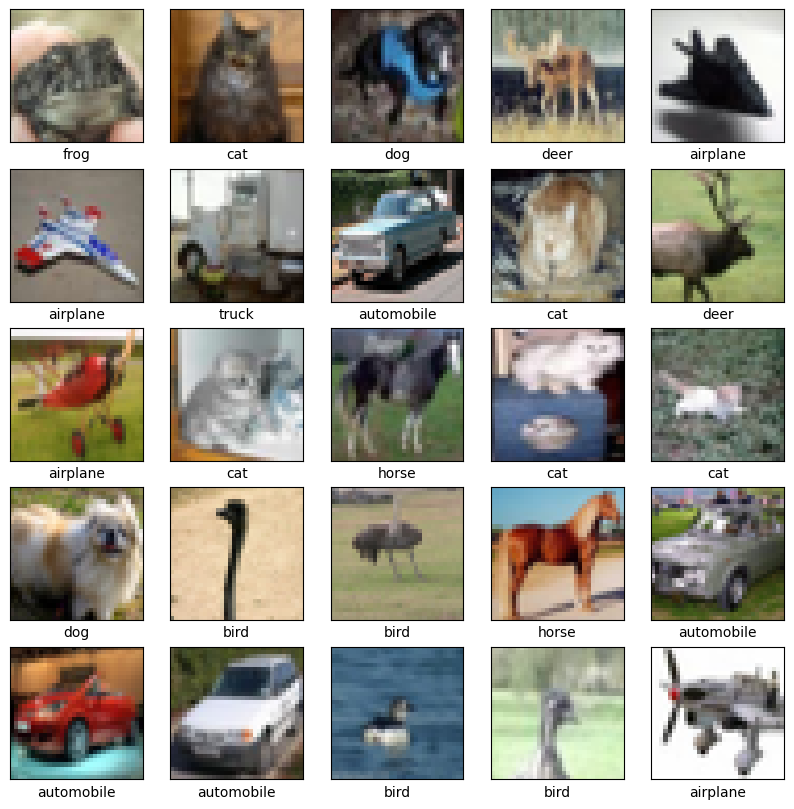

In [11]:
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+25])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i+25][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [6]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 30, 30, 32)        896       


 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     


 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     


Total params: 56,320


Trainable params: 56,320


Non-trainable params: 0


_________________________________________________________________


Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [8]:
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 30, 30, 32)        896       


 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         


 )                                                               


 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     


 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         


 2D)                                                             


 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     


 flatten (Flatten)           (None, 1024)              0         


 dense (Dense)               (None, 64)                65600     


 dense_1 (Dense)             (None, 10)                650       


Total params: 122,570


Trainable params: 122,570


Non-trainable params: 0


_________________________________________________________________


The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10



   1/1563 [..............................] - ETA: 1:29:46 - loss: 2.3249 - accuracy: 0.0312


  14/1563 [..............................] - ETA: 6s - loss: 2.3029 - accuracy: 0.0960     


  27/1563 [..............................] - ETA: 6s - loss: 2.2825 - accuracy: 0.1019


  41/1563 [..............................] - ETA: 5s - loss: 2.2446 - accuracy: 0.1265


  55/1563 [>.............................] - ETA: 5s - loss: 2.2164 - accuracy: 0.1426


  69/1563 [>.............................] - ETA: 5s - loss: 2.1852 - accuracy: 0.1567


  82/1563 [>.............................] - ETA: 5s - loss: 2.1564 - accuracy: 0.1707


  96/1563 [>.............................] - ETA: 5s - loss: 2.1299 - accuracy: 0.1852


 110/1563 [=>............................] - ETA: 5s - loss: 2.1122 - accuracy: 0.1957


 124/1563 [=>............................] - ETA: 5s - loss: 2.0920 - accuracy: 0.2026


 138/1563 [=>............................] - ETA: 5s - loss: 2.0584 - accuracy: 0.2149


 152/1563 [=>............................] - ETA: 5s - loss: 2.0417 - accuracy: 0.2272


 166/1563 [==>...........................] - ETA: 5s - loss: 2.0248 - accuracy: 0.2357


 180/1563 [==>...........................] - ETA: 5s - loss: 2.0097 - accuracy: 0.2429


 194/1563 [==>...........................] - ETA: 5s - loss: 1.9954 - accuracy: 0.2497


 208/1563 [==>...........................] - ETA: 5s - loss: 1.9808 - accuracy: 0.2548


 222/1563 [===>..........................] - ETA: 5s - loss: 1.9704 - accuracy: 0.2586


 236/1563 [===>..........................] - ETA: 4s - loss: 1.9578 - accuracy: 0.2634


 250/1563 [===>..........................] - ETA: 4s - loss: 1.9467 - accuracy: 0.2673


 264/1563 [====>.........................] - ETA: 4s - loss: 1.9389 - accuracy: 0.2717


 278/1563 [====>.........................] - ETA: 4s - loss: 1.9286 - accuracy: 0.2764


 292/1563 [====>.........................] - ETA: 4s - loss: 1.9177 - accuracy: 0.2805


 306/1563 [====>.........................] - ETA: 4s - loss: 1.9060 - accuracy: 0.2855


 320/1563 [=====>........................] - ETA: 4s - loss: 1.8965 - accuracy: 0.2903


 334/1563 [=====>........................] - ETA: 4s - loss: 1.8856 - accuracy: 0.2943


 348/1563 [=====>........................] - ETA: 4s - loss: 1.8772 - accuracy: 0.2978


 362/1563 [=====>........................] - ETA: 4s - loss: 1.8667 - accuracy: 0.3028


 376/1563 [======>.......................] - ETA: 4s - loss: 1.8559 - accuracy: 0.3079


 390/1563 [======>.......................] - ETA: 4s - loss: 1.8486 - accuracy: 0.3106


 404/1563 [======>.......................] - ETA: 4s - loss: 1.8444 - accuracy: 0.3130


 418/1563 [=======>......................] - ETA: 4s - loss: 1.8370 - accuracy: 0.3158


 432/1563 [=======>......................] - ETA: 4s - loss: 1.8291 - accuracy: 0.3189


 446/1563 [=======>......................] - ETA: 4s - loss: 1.8202 - accuracy: 0.3226


 460/1563 [=======>......................] - ETA: 4s - loss: 1.8143 - accuracy: 0.3253


 474/1563 [========>.....................] - ETA: 4s - loss: 1.8095 - accuracy: 0.3277


 488/1563 [========>.....................] - ETA: 4s - loss: 1.8046 - accuracy: 0.3291


 502/1563 [========>.....................] - ETA: 3s - loss: 1.7989 - accuracy: 0.3309


 516/1563 [========>.....................] - ETA: 3s - loss: 1.7919 - accuracy: 0.3332


 530/1563 [=========>....................] - ETA: 3s - loss: 1.7854 - accuracy: 0.3355


 544/1563 [=========>....................] - ETA: 3s - loss: 1.7789 - accuracy: 0.3375


 558/1563 [=========>....................] - ETA: 3s - loss: 1.7733 - accuracy: 0.3402


 572/1563 [=========>....................] - ETA: 3s - loss: 1.7667 - accuracy: 0.3423


 586/1563 [==========>...................] - ETA: 3s - loss: 1.7620 - accuracy: 0.3442


 600/1563 [==========>...................] - ETA: 3s - loss: 1.7575 - accuracy: 0.3466


 614/1563 [==========>...................] - ETA: 3s - loss: 1.7512 - accuracy: 0.3492


 628/1563 [===========>..................] - ETA: 3s - loss: 1.7462 - accuracy: 0.3514


 642/1563 [===========>..................] - ETA: 3s - loss: 1.7423 - accuracy: 0.3539


 656/1563 [===========>..................] - ETA: 3s - loss: 1.7376 - accuracy: 0.3562


 670/1563 [===========>..................] - ETA: 3s - loss: 1.7337 - accuracy: 0.3587


 684/1563 [============>.................] - ETA: 3s - loss: 1.7284 - accuracy: 0.3601


 698/1563 [============>.................] - ETA: 3s - loss: 1.7242 - accuracy: 0.3619


 712/1563 [============>.................] - ETA: 3s - loss: 1.7195 - accuracy: 0.3639


 726/1563 [============>.................] - ETA: 3s - loss: 1.7137 - accuracy: 0.3657


 740/1563 [=============>................] - ETA: 3s - loss: 1.7101 - accuracy: 0.3673


 754/1563 [=============>................] - ETA: 3s - loss: 1.7056 - accuracy: 0.3686


 768/1563 [=============>................] - ETA: 2s - loss: 1.7007 - accuracy: 0.3710


 782/1563 [==============>...............] - ETA: 2s - loss: 1.6947 - accuracy: 0.3725


 796/1563 [==============>...............] - ETA: 2s - loss: 1.6901 - accuracy: 0.3743


 810/1563 [==============>...............] - ETA: 2s - loss: 1.6869 - accuracy: 0.3753


 824/1563 [==============>...............] - ETA: 2s - loss: 1.6836 - accuracy: 0.3764


 838/1563 [===============>..............] - ETA: 2s - loss: 1.6814 - accuracy: 0.3772


 852/1563 [===============>..............] - ETA: 2s - loss: 1.6778 - accuracy: 0.3786


 866/1563 [===============>..............] - ETA: 2s - loss: 1.6732 - accuracy: 0.3806


 880/1563 [===============>..............] - ETA: 2s - loss: 1.6690 - accuracy: 0.3819


 894/1563 [================>.............] - ETA: 2s - loss: 1.6665 - accuracy: 0.3837


 908/1563 [================>.............] - ETA: 2s - loss: 1.6623 - accuracy: 0.3861


 922/1563 [================>.............] - ETA: 2s - loss: 1.6588 - accuracy: 0.3877


 936/1563 [================>.............] - ETA: 2s - loss: 1.6552 - accuracy: 0.3895


 950/1563 [=================>............] - ETA: 2s - loss: 1.6511 - accuracy: 0.3907


 964/1563 [=================>............] - ETA: 2s - loss: 1.6473 - accuracy: 0.3922


 978/1563 [=================>............] - ETA: 2s - loss: 1.6431 - accuracy: 0.3939


 992/1563 [==================>...........] - ETA: 2s - loss: 1.6381 - accuracy: 0.3957


1006/1563 [==================>...........] - ETA: 2s - loss: 1.6345 - accuracy: 0.3971


1020/1563 [==================>...........] - ETA: 2s - loss: 1.6316 - accuracy: 0.3981


1034/1563 [==================>...........] - ETA: 1s - loss: 1.6280 - accuracy: 0.3998


1048/1563 [===================>..........] - ETA: 1s - loss: 1.6245 - accuracy: 0.4017


1062/1563 [===================>..........] - ETA: 1s - loss: 1.6207 - accuracy: 0.4032


1076/1563 [===================>..........] - ETA: 1s - loss: 1.6181 - accuracy: 0.4038


1090/1563 [===================>..........] - ETA: 1s - loss: 1.6143 - accuracy: 0.4051


1104/1563 [====================>.........] - ETA: 1s - loss: 1.6122 - accuracy: 0.4057


1118/1563 [====================>.........] - ETA: 1s - loss: 1.6090 - accuracy: 0.4069


1132/1563 [====================>.........] - ETA: 1s - loss: 1.6053 - accuracy: 0.4085


1146/1563 [====================>.........] - ETA: 1s - loss: 1.6028 - accuracy: 0.4099


1160/1563 [=====================>........] - ETA: 1s - loss: 1.5989 - accuracy: 0.4114


1174/1563 [=====================>........] - ETA: 1s - loss: 1.5967 - accuracy: 0.4122


1188/1563 [=====================>........] - ETA: 1s - loss: 1.5941 - accuracy: 0.4135


1202/1563 [======================>.......] - ETA: 1s - loss: 1.5911 - accuracy: 0.4146


1216/1563 [======================>.......] - ETA: 1s - loss: 1.5900 - accuracy: 0.4154


1230/1563 [======================>.......] - ETA: 1s - loss: 1.5875 - accuracy: 0.4163


1244/1563 [======================>.......] - ETA: 1s - loss: 1.5847 - accuracy: 0.4174


1258/1563 [=======================>......] - ETA: 1s - loss: 1.5815 - accuracy: 0.4188


1272/1563 [=======================>......] - ETA: 1s - loss: 1.5798 - accuracy: 0.4197


1286/1563 [=======================>......] - ETA: 1s - loss: 1.5772 - accuracy: 0.4208


1300/1563 [=======================>......] - ETA: 0s - loss: 1.5735 - accuracy: 0.4225


1314/1563 [========================>.....] - ETA: 0s - loss: 1.5715 - accuracy: 0.4233


1328/1563 [========================>.....] - ETA: 0s - loss: 1.5691 - accuracy: 0.4245


1342/1563 [========================>.....] - ETA: 0s - loss: 1.5671 - accuracy: 0.4256


1356/1563 [=========================>....] - ETA: 0s - loss: 1.5640 - accuracy: 0.4269


1370/1563 [=========================>....] - ETA: 0s - loss: 1.5624 - accuracy: 0.4276


1384/1563 [=========================>....] - ETA: 0s - loss: 1.5595 - accuracy: 0.4290


1399/1563 [=========================>....] - ETA: 0s - loss: 1.5571 - accuracy: 0.4299


1413/1563 [==========================>...] - ETA: 0s - loss: 1.5549 - accuracy: 0.4308


1427/1563 [==========================>...] - ETA: 0s - loss: 1.5526 - accuracy: 0.4316


1441/1563 [==========================>...] - ETA: 0s - loss: 1.5506 - accuracy: 0.4325


1455/1563 [==========================>...] - ETA: 0s - loss: 1.5487 - accuracy: 0.4336


1469/1563 [===========================>..] - ETA: 0s - loss: 1.5455 - accuracy: 0.4348


1483/1563 [===========================>..] - ETA: 0s - loss: 1.5428 - accuracy: 0.4358


1497/1563 [===========================>..] - ETA: 0s - loss: 1.5413 - accuracy: 0.4365


1511/1563 [============================>.] - ETA: 0s - loss: 1.5383 - accuracy: 0.4377


1526/1563 [============================>.] - ETA: 0s - loss: 1.5354 - accuracy: 0.4386


1541/1563 [============================>.] - ETA: 0s - loss: 1.5337 - accuracy: 0.4395


1555/1563 [============================>.] - ETA: 0s - loss: 1.5327 - accuracy: 0.4402


1563/1563 [==============================] - ETA: 0s - loss: 1.5316 - accuracy: 0.4406


1563/1563 [==============================] - 10s 4ms/step - loss: 1.5316 - accuracy: 0.4406 - val_loss: 1.2891 - val_accuracy: 0.5438


Epoch 2/10



   1/1563 [..............................] - ETA: 7s - loss: 0.9495 - accuracy: 0.7812


  15/1563 [..............................] - ETA: 5s - loss: 1.1785 - accuracy: 0.6146


  29/1563 [..............................] - ETA: 5s - loss: 1.2202 - accuracy: 0.5776


  43/1563 [..............................] - ETA: 5s - loss: 1.2412 - accuracy: 0.5574


  57/1563 [>.............................] - ETA: 5s - loss: 1.2479 - accuracy: 0.5565


  71/1563 [>.............................] - ETA: 5s - loss: 1.2447 - accuracy: 0.5546


  85/1563 [>.............................] - ETA: 5s - loss: 1.2577 - accuracy: 0.5537


  99/1563 [>.............................] - ETA: 5s - loss: 1.2489 - accuracy: 0.5606


 113/1563 [=>............................] - ETA: 5s - loss: 1.2481 - accuracy: 0.5619


 127/1563 [=>............................] - ETA: 5s - loss: 1.2466 - accuracy: 0.5598


 141/1563 [=>............................] - ETA: 5s - loss: 1.2487 - accuracy: 0.5596


 155/1563 [=>............................] - ETA: 5s - loss: 1.2362 - accuracy: 0.5609


 169/1563 [==>...........................] - ETA: 5s - loss: 1.2380 - accuracy: 0.5603


 183/1563 [==>...........................] - ETA: 5s - loss: 1.2328 - accuracy: 0.5611


 197/1563 [==>...........................] - ETA: 5s - loss: 1.2307 - accuracy: 0.5604


 211/1563 [===>..........................] - ETA: 4s - loss: 1.2285 - accuracy: 0.5604


 225/1563 [===>..........................] - ETA: 4s - loss: 1.2303 - accuracy: 0.5615


 239/1563 [===>..........................] - ETA: 4s - loss: 1.2268 - accuracy: 0.5616


 253/1563 [===>..........................] - ETA: 4s - loss: 1.2265 - accuracy: 0.5604


 267/1563 [====>.........................] - ETA: 4s - loss: 1.2272 - accuracy: 0.5607


 281/1563 [====>.........................] - ETA: 4s - loss: 1.2277 - accuracy: 0.5609


 295/1563 [====>.........................] - ETA: 4s - loss: 1.2258 - accuracy: 0.5608


 309/1563 [====>.........................] - ETA: 4s - loss: 1.2229 - accuracy: 0.5624


 323/1563 [=====>........................] - ETA: 4s - loss: 1.2234 - accuracy: 0.5623


 337/1563 [=====>........................] - ETA: 4s - loss: 1.2243 - accuracy: 0.5617


 351/1563 [=====>........................] - ETA: 4s - loss: 1.2223 - accuracy: 0.5626


 365/1563 [======>.......................] - ETA: 4s - loss: 1.2216 - accuracy: 0.5624


 379/1563 [======>.......................] - ETA: 4s - loss: 1.2267 - accuracy: 0.5606


 393/1563 [======>.......................] - ETA: 4s - loss: 1.2251 - accuracy: 0.5615


 407/1563 [======>.......................] - ETA: 4s - loss: 1.2229 - accuracy: 0.5625


 421/1563 [=======>......................] - ETA: 4s - loss: 1.2203 - accuracy: 0.5636


 436/1563 [=======>......................] - ETA: 4s - loss: 1.2211 - accuracy: 0.5639


 450/1563 [=======>......................] - ETA: 4s - loss: 1.2206 - accuracy: 0.5642


 464/1563 [=======>......................] - ETA: 4s - loss: 1.2198 - accuracy: 0.5647


 478/1563 [========>.....................] - ETA: 3s - loss: 1.2174 - accuracy: 0.5662


 492/1563 [========>.....................] - ETA: 3s - loss: 1.2192 - accuracy: 0.5657


 506/1563 [========>.....................] - ETA: 3s - loss: 1.2194 - accuracy: 0.5654


 520/1563 [========>.....................] - ETA: 3s - loss: 1.2208 - accuracy: 0.5650


 534/1563 [=========>....................] - ETA: 3s - loss: 1.2202 - accuracy: 0.5658


 548/1563 [=========>....................] - ETA: 3s - loss: 1.2197 - accuracy: 0.5658


 562/1563 [=========>....................] - ETA: 3s - loss: 1.2207 - accuracy: 0.5659


 576/1563 [==========>...................] - ETA: 3s - loss: 1.2190 - accuracy: 0.5661


 590/1563 [==========>...................] - ETA: 3s - loss: 1.2181 - accuracy: 0.5668


 605/1563 [==========>...................] - ETA: 3s - loss: 1.2181 - accuracy: 0.5668


 619/1563 [==========>...................] - ETA: 3s - loss: 1.2188 - accuracy: 0.5663


 634/1563 [===========>..................] - ETA: 3s - loss: 1.2185 - accuracy: 0.5667


 648/1563 [===========>..................] - ETA: 3s - loss: 1.2175 - accuracy: 0.5668


 662/1563 [===========>..................] - ETA: 3s - loss: 1.2159 - accuracy: 0.5670


 676/1563 [===========>..................] - ETA: 3s - loss: 1.2152 - accuracy: 0.5674


 690/1563 [============>.................] - ETA: 3s - loss: 1.2153 - accuracy: 0.5674


 704/1563 [============>.................] - ETA: 3s - loss: 1.2158 - accuracy: 0.5673


 718/1563 [============>.................] - ETA: 3s - loss: 1.2169 - accuracy: 0.5669


 732/1563 [=============>................] - ETA: 3s - loss: 1.2163 - accuracy: 0.5673


 746/1563 [=============>................] - ETA: 2s - loss: 1.2159 - accuracy: 0.5674


 760/1563 [=============>................] - ETA: 2s - loss: 1.2139 - accuracy: 0.5680


 774/1563 [=============>................] - ETA: 2s - loss: 1.2107 - accuracy: 0.5691


 788/1563 [==============>...............] - ETA: 2s - loss: 1.2117 - accuracy: 0.5686


 802/1563 [==============>...............] - ETA: 2s - loss: 1.2130 - accuracy: 0.5681


 816/1563 [==============>...............] - ETA: 2s - loss: 1.2126 - accuracy: 0.5686


 830/1563 [==============>...............] - ETA: 2s - loss: 1.2115 - accuracy: 0.5688


 844/1563 [===============>..............] - ETA: 2s - loss: 1.2105 - accuracy: 0.5689


 858/1563 [===============>..............] - ETA: 2s - loss: 1.2085 - accuracy: 0.5695


 872/1563 [===============>..............] - ETA: 2s - loss: 1.2071 - accuracy: 0.5698


 886/1563 [================>.............] - ETA: 2s - loss: 1.2063 - accuracy: 0.5704


 900/1563 [================>.............] - ETA: 2s - loss: 1.2062 - accuracy: 0.5705


 915/1563 [================>.............] - ETA: 2s - loss: 1.2054 - accuracy: 0.5709


 929/1563 [================>.............] - ETA: 2s - loss: 1.2057 - accuracy: 0.5704


 943/1563 [=================>............] - ETA: 2s - loss: 1.2053 - accuracy: 0.5703


 957/1563 [=================>............] - ETA: 2s - loss: 1.2038 - accuracy: 0.5707


 971/1563 [=================>............] - ETA: 2s - loss: 1.2042 - accuracy: 0.5704


 984/1563 [=================>............] - ETA: 2s - loss: 1.2030 - accuracy: 0.5709


 998/1563 [==================>...........] - ETA: 2s - loss: 1.2019 - accuracy: 0.5710


1012/1563 [==================>...........] - ETA: 2s - loss: 1.2016 - accuracy: 0.5708


1026/1563 [==================>...........] - ETA: 1s - loss: 1.2010 - accuracy: 0.5713


1040/1563 [==================>...........] - ETA: 1s - loss: 1.2005 - accuracy: 0.5716


1054/1563 [===================>..........] - ETA: 1s - loss: 1.1995 - accuracy: 0.5718


1068/1563 [===================>..........] - ETA: 1s - loss: 1.1979 - accuracy: 0.5724


1082/1563 [===================>..........] - ETA: 1s - loss: 1.1970 - accuracy: 0.5726


1096/1563 [====================>.........] - ETA: 1s - loss: 1.1968 - accuracy: 0.5727


1110/1563 [====================>.........] - ETA: 1s - loss: 1.1963 - accuracy: 0.5730


1123/1563 [====================>.........] - ETA: 1s - loss: 1.1952 - accuracy: 0.5735


1137/1563 [====================>.........] - ETA: 1s - loss: 1.1948 - accuracy: 0.5736


1151/1563 [=====================>........] - ETA: 1s - loss: 1.1937 - accuracy: 0.5738


1165/1563 [=====================>........] - ETA: 1s - loss: 1.1920 - accuracy: 0.5745


1179/1563 [=====================>........] - ETA: 1s - loss: 1.1911 - accuracy: 0.5750


1193/1563 [=====================>........] - ETA: 1s - loss: 1.1904 - accuracy: 0.5752


1207/1563 [======================>.......] - ETA: 1s - loss: 1.1919 - accuracy: 0.5749


1221/1563 [======================>.......] - ETA: 1s - loss: 1.1917 - accuracy: 0.5749


1235/1563 [======================>.......] - ETA: 1s - loss: 1.1905 - accuracy: 0.5755


1249/1563 [======================>.......] - ETA: 1s - loss: 1.1896 - accuracy: 0.5755


1263/1563 [=======================>......] - ETA: 1s - loss: 1.1889 - accuracy: 0.5755


1277/1563 [=======================>......] - ETA: 1s - loss: 1.1880 - accuracy: 0.5760


1291/1563 [=======================>......] - ETA: 1s - loss: 1.1876 - accuracy: 0.5766


1305/1563 [========================>.....] - ETA: 0s - loss: 1.1863 - accuracy: 0.5767


1319/1563 [========================>.....] - ETA: 0s - loss: 1.1857 - accuracy: 0.5771


1333/1563 [========================>.....] - ETA: 0s - loss: 1.1856 - accuracy: 0.5772


1347/1563 [========================>.....] - ETA: 0s - loss: 1.1855 - accuracy: 0.5772


1361/1563 [=========================>....] - ETA: 0s - loss: 1.1852 - accuracy: 0.5772


1375/1563 [=========================>....] - ETA: 0s - loss: 1.1853 - accuracy: 0.5773


1389/1563 [=========================>....] - ETA: 0s - loss: 1.1841 - accuracy: 0.5775


1403/1563 [=========================>....] - ETA: 0s - loss: 1.1836 - accuracy: 0.5775


1417/1563 [==========================>...] - ETA: 0s - loss: 1.1836 - accuracy: 0.5778


1431/1563 [==========================>...] - ETA: 0s - loss: 1.1835 - accuracy: 0.5779


1445/1563 [==========================>...] - ETA: 0s - loss: 1.1833 - accuracy: 0.5780


1459/1563 [===========================>..] - ETA: 0s - loss: 1.1832 - accuracy: 0.5785


1473/1563 [===========================>..] - ETA: 0s - loss: 1.1830 - accuracy: 0.5784


1487/1563 [===========================>..] - ETA: 0s - loss: 1.1822 - accuracy: 0.5787


1501/1563 [===========================>..] - ETA: 0s - loss: 1.1819 - accuracy: 0.5790


1515/1563 [============================>.] - ETA: 0s - loss: 1.1811 - accuracy: 0.5795


1529/1563 [============================>.] - ETA: 0s - loss: 1.1800 - accuracy: 0.5801


1543/1563 [============================>.] - ETA: 0s - loss: 1.1792 - accuracy: 0.5807


1557/1563 [============================>.] - ETA: 0s - loss: 1.1788 - accuracy: 0.5808


1563/1563 [==============================] - 6s 4ms/step - loss: 1.1786 - accuracy: 0.5810 - val_loss: 1.1129 - val_accuracy: 0.6107


Epoch 3/10



   1/1563 [..............................] - ETA: 8s - loss: 1.1019 - accuracy: 0.5625


  15/1563 [..............................] - ETA: 5s - loss: 1.0874 - accuracy: 0.6187


  29/1563 [..............................] - ETA: 5s - loss: 1.0524 - accuracy: 0.6369


  43/1563 [..............................] - ETA: 5s - loss: 1.0653 - accuracy: 0.6337


  57/1563 [>.............................] - ETA: 5s - loss: 1.0462 - accuracy: 0.6371


  71/1563 [>.............................] - ETA: 5s - loss: 1.0393 - accuracy: 0.6373


  85/1563 [>.............................] - ETA: 5s - loss: 1.0504 - accuracy: 0.6342


  99/1563 [>.............................] - ETA: 5s - loss: 1.0427 - accuracy: 0.6348


 113/1563 [=>............................] - ETA: 5s - loss: 1.0237 - accuracy: 0.6405


 127/1563 [=>............................] - ETA: 5s - loss: 1.0294 - accuracy: 0.6390


 141/1563 [=>............................] - ETA: 5s - loss: 1.0405 - accuracy: 0.6328


 155/1563 [=>............................] - ETA: 5s - loss: 1.0464 - accuracy: 0.6290


 169/1563 [==>...........................] - ETA: 5s - loss: 1.0346 - accuracy: 0.6315


 183/1563 [==>...........................] - ETA: 5s - loss: 1.0285 - accuracy: 0.6335


 197/1563 [==>...........................] - ETA: 5s - loss: 1.0343 - accuracy: 0.6332


 211/1563 [===>..........................] - ETA: 5s - loss: 1.0364 - accuracy: 0.6328


 225/1563 [===>..........................] - ETA: 4s - loss: 1.0361 - accuracy: 0.6332


 239/1563 [===>..........................] - ETA: 4s - loss: 1.0363 - accuracy: 0.6327


 253/1563 [===>..........................] - ETA: 4s - loss: 1.0403 - accuracy: 0.6299


 267/1563 [====>.........................] - ETA: 4s - loss: 1.0392 - accuracy: 0.6294


 281/1563 [====>.........................] - ETA: 4s - loss: 1.0398 - accuracy: 0.6290


 295/1563 [====>.........................] - ETA: 4s - loss: 1.0416 - accuracy: 0.6283


 309/1563 [====>.........................] - ETA: 4s - loss: 1.0391 - accuracy: 0.6290


 323/1563 [=====>........................] - ETA: 4s - loss: 1.0380 - accuracy: 0.6300


 337/1563 [=====>........................] - ETA: 4s - loss: 1.0387 - accuracy: 0.6301


 351/1563 [=====>........................] - ETA: 4s - loss: 1.0439 - accuracy: 0.6283


 365/1563 [======>.......................] - ETA: 4s - loss: 1.0424 - accuracy: 0.6295


 379/1563 [======>.......................] - ETA: 4s - loss: 1.0426 - accuracy: 0.6290


 393/1563 [======>.......................] - ETA: 4s - loss: 1.0417 - accuracy: 0.6290


 407/1563 [======>.......................] - ETA: 4s - loss: 1.0414 - accuracy: 0.6290


 421/1563 [=======>......................] - ETA: 4s - loss: 1.0419 - accuracy: 0.6290


 435/1563 [=======>......................] - ETA: 4s - loss: 1.0435 - accuracy: 0.6283


 449/1563 [=======>......................] - ETA: 4s - loss: 1.0430 - accuracy: 0.6279


 463/1563 [=======>......................] - ETA: 4s - loss: 1.0410 - accuracy: 0.6289


 477/1563 [========>.....................] - ETA: 4s - loss: 1.0425 - accuracy: 0.6283


 491/1563 [========>.....................] - ETA: 3s - loss: 1.0424 - accuracy: 0.6287


 505/1563 [========>.....................] - ETA: 3s - loss: 1.0420 - accuracy: 0.6293


 519/1563 [========>.....................] - ETA: 3s - loss: 1.0448 - accuracy: 0.6285


 533/1563 [=========>....................] - ETA: 3s - loss: 1.0448 - accuracy: 0.6284


 547/1563 [=========>....................] - ETA: 3s - loss: 1.0426 - accuracy: 0.6289


 561/1563 [=========>....................] - ETA: 3s - loss: 1.0443 - accuracy: 0.6281


 575/1563 [==========>...................] - ETA: 3s - loss: 1.0460 - accuracy: 0.6276


 589/1563 [==========>...................] - ETA: 3s - loss: 1.0437 - accuracy: 0.6285


 603/1563 [==========>...................] - ETA: 3s - loss: 1.0433 - accuracy: 0.6289


 616/1563 [==========>...................] - ETA: 3s - loss: 1.0442 - accuracy: 0.6281


 630/1563 [===========>..................] - ETA: 3s - loss: 1.0435 - accuracy: 0.6280


 644/1563 [===========>..................] - ETA: 3s - loss: 1.0434 - accuracy: 0.6276


 658/1563 [===========>..................] - ETA: 3s - loss: 1.0455 - accuracy: 0.6272


 672/1563 [===========>..................] - ETA: 3s - loss: 1.0434 - accuracy: 0.6280


 686/1563 [============>.................] - ETA: 3s - loss: 1.0430 - accuracy: 0.6280


 700/1563 [============>.................] - ETA: 3s - loss: 1.0426 - accuracy: 0.6283


 714/1563 [============>.................] - ETA: 3s - loss: 1.0441 - accuracy: 0.6280


 728/1563 [============>.................] - ETA: 3s - loss: 1.0457 - accuracy: 0.6282


 742/1563 [=============>................] - ETA: 3s - loss: 1.0451 - accuracy: 0.6286


 756/1563 [=============>................] - ETA: 3s - loss: 1.0443 - accuracy: 0.6287


 770/1563 [=============>................] - ETA: 2s - loss: 1.0438 - accuracy: 0.6289


 784/1563 [==============>...............] - ETA: 2s - loss: 1.0421 - accuracy: 0.6295


 798/1563 [==============>...............] - ETA: 2s - loss: 1.0428 - accuracy: 0.6292


 812/1563 [==============>...............] - ETA: 2s - loss: 1.0407 - accuracy: 0.6301


 826/1563 [==============>...............] - ETA: 2s - loss: 1.0397 - accuracy: 0.6305


 840/1563 [===============>..............] - ETA: 2s - loss: 1.0398 - accuracy: 0.6304


 854/1563 [===============>..............] - ETA: 2s - loss: 1.0403 - accuracy: 0.6300


 868/1563 [===============>..............] - ETA: 2s - loss: 1.0404 - accuracy: 0.6297


 882/1563 [===============>..............] - ETA: 2s - loss: 1.0406 - accuracy: 0.6299


 896/1563 [================>.............] - ETA: 2s - loss: 1.0398 - accuracy: 0.6307


 910/1563 [================>.............] - ETA: 2s - loss: 1.0398 - accuracy: 0.6308


 924/1563 [================>.............] - ETA: 2s - loss: 1.0403 - accuracy: 0.6306


 938/1563 [=================>............] - ETA: 2s - loss: 1.0397 - accuracy: 0.6310


 952/1563 [=================>............] - ETA: 2s - loss: 1.0381 - accuracy: 0.6310


 966/1563 [=================>............] - ETA: 2s - loss: 1.0371 - accuracy: 0.6313


 980/1563 [=================>............] - ETA: 2s - loss: 1.0371 - accuracy: 0.6315


 994/1563 [==================>...........] - ETA: 2s - loss: 1.0377 - accuracy: 0.6312


1008/1563 [==================>...........] - ETA: 2s - loss: 1.0372 - accuracy: 0.6316


1022/1563 [==================>...........] - ETA: 2s - loss: 1.0362 - accuracy: 0.6320


1036/1563 [==================>...........] - ETA: 1s - loss: 1.0355 - accuracy: 0.6319


1050/1563 [===================>..........] - ETA: 1s - loss: 1.0359 - accuracy: 0.6321


1064/1563 [===================>..........] - ETA: 1s - loss: 1.0367 - accuracy: 0.6324


1078/1563 [===================>..........] - ETA: 1s - loss: 1.0353 - accuracy: 0.6330


1092/1563 [===================>..........] - ETA: 1s - loss: 1.0350 - accuracy: 0.6332


1106/1563 [====================>.........] - ETA: 1s - loss: 1.0342 - accuracy: 0.6333


1120/1563 [====================>.........] - ETA: 1s - loss: 1.0349 - accuracy: 0.6329


1134/1563 [====================>.........] - ETA: 1s - loss: 1.0340 - accuracy: 0.6335


1149/1563 [=====================>........] - ETA: 1s - loss: 1.0342 - accuracy: 0.6333


1163/1563 [=====================>........] - ETA: 1s - loss: 1.0348 - accuracy: 0.6333


1177/1563 [=====================>........] - ETA: 1s - loss: 1.0343 - accuracy: 0.6338


1191/1563 [=====================>........] - ETA: 1s - loss: 1.0342 - accuracy: 0.6338


1205/1563 [======================>.......] - ETA: 1s - loss: 1.0335 - accuracy: 0.6343


1219/1563 [======================>.......] - ETA: 1s - loss: 1.0327 - accuracy: 0.6345


1233/1563 [======================>.......] - ETA: 1s - loss: 1.0328 - accuracy: 0.6343


1247/1563 [======================>.......] - ETA: 1s - loss: 1.0330 - accuracy: 0.6340


1261/1563 [=======================>......] - ETA: 1s - loss: 1.0346 - accuracy: 0.6335


1275/1563 [=======================>......] - ETA: 1s - loss: 1.0349 - accuracy: 0.6336


1289/1563 [=======================>......] - ETA: 1s - loss: 1.0347 - accuracy: 0.6339


1303/1563 [========================>.....] - ETA: 0s - loss: 1.0343 - accuracy: 0.6343


1317/1563 [========================>.....] - ETA: 0s - loss: 1.0338 - accuracy: 0.6347


1331/1563 [========================>.....] - ETA: 0s - loss: 1.0335 - accuracy: 0.6350


1345/1563 [========================>.....] - ETA: 0s - loss: 1.0331 - accuracy: 0.6352


1359/1563 [=========================>....] - ETA: 0s - loss: 1.0327 - accuracy: 0.6353


1373/1563 [=========================>....] - ETA: 0s - loss: 1.0324 - accuracy: 0.6354


1388/1563 [=========================>....] - ETA: 0s - loss: 1.0328 - accuracy: 0.6351


1402/1563 [=========================>....] - ETA: 0s - loss: 1.0334 - accuracy: 0.6351


1416/1563 [==========================>...] - ETA: 0s - loss: 1.0321 - accuracy: 0.6359


1430/1563 [==========================>...] - ETA: 0s - loss: 1.0312 - accuracy: 0.6364


1444/1563 [==========================>...] - ETA: 0s - loss: 1.0304 - accuracy: 0.6367


1458/1563 [==========================>...] - ETA: 0s - loss: 1.0297 - accuracy: 0.6373


1472/1563 [===========================>..] - ETA: 0s - loss: 1.0303 - accuracy: 0.6370


1486/1563 [===========================>..] - ETA: 0s - loss: 1.0290 - accuracy: 0.6374


1500/1563 [===========================>..] - ETA: 0s - loss: 1.0275 - accuracy: 0.6378


1515/1563 [============================>.] - ETA: 0s - loss: 1.0265 - accuracy: 0.6382


1529/1563 [============================>.] - ETA: 0s - loss: 1.0256 - accuracy: 0.6386


1543/1563 [============================>.] - ETA: 0s - loss: 1.0250 - accuracy: 0.6391


1557/1563 [============================>.] - ETA: 0s - loss: 1.0251 - accuracy: 0.6389


1563/1563 [==============================] - 6s 4ms/step - loss: 1.0249 - accuracy: 0.6390 - val_loss: 1.0288 - val_accuracy: 0.6382


Epoch 4/10



   1/1563 [..............................] - ETA: 7s - loss: 0.9883 - accuracy: 0.6250


  15/1563 [..............................] - ETA: 5s - loss: 1.0437 - accuracy: 0.6146


  29/1563 [..............................] - ETA: 5s - loss: 1.0433 - accuracy: 0.6142


  43/1563 [..............................] - ETA: 5s - loss: 1.0292 - accuracy: 0.6257


  57/1563 [>.............................] - ETA: 5s - loss: 1.0038 - accuracy: 0.6349


  71/1563 [>.............................] - ETA: 5s - loss: 0.9961 - accuracy: 0.6386


  85/1563 [>.............................] - ETA: 5s - loss: 0.9897 - accuracy: 0.6441


  99/1563 [>.............................] - ETA: 5s - loss: 0.9802 - accuracy: 0.6493


 113/1563 [=>............................] - ETA: 5s - loss: 0.9636 - accuracy: 0.6565


 127/1563 [=>............................] - ETA: 5s - loss: 0.9598 - accuracy: 0.6558


 142/1563 [=>............................] - ETA: 5s - loss: 0.9491 - accuracy: 0.6618


 156/1563 [=>............................] - ETA: 5s - loss: 0.9576 - accuracy: 0.6589


 170/1563 [==>...........................] - ETA: 5s - loss: 0.9599 - accuracy: 0.6568


 184/1563 [==>...........................] - ETA: 5s - loss: 0.9604 - accuracy: 0.6566


 198/1563 [==>...........................] - ETA: 5s - loss: 0.9619 - accuracy: 0.6566


 212/1563 [===>..........................] - ETA: 4s - loss: 0.9622 - accuracy: 0.6580


 226/1563 [===>..........................] - ETA: 4s - loss: 0.9556 - accuracy: 0.6611


 240/1563 [===>..........................] - ETA: 4s - loss: 0.9575 - accuracy: 0.6607


 254/1563 [===>..........................] - ETA: 4s - loss: 0.9543 - accuracy: 0.6633


 268/1563 [====>.........................] - ETA: 4s - loss: 0.9526 - accuracy: 0.6638


 282/1563 [====>.........................] - ETA: 4s - loss: 0.9486 - accuracy: 0.6656


 296/1563 [====>.........................] - ETA: 4s - loss: 0.9499 - accuracy: 0.6644


 310/1563 [====>.........................] - ETA: 4s - loss: 0.9483 - accuracy: 0.6648


 324/1563 [=====>........................] - ETA: 4s - loss: 0.9450 - accuracy: 0.6661


 338/1563 [=====>........................] - ETA: 4s - loss: 0.9423 - accuracy: 0.6674


 352/1563 [=====>........................] - ETA: 4s - loss: 0.9409 - accuracy: 0.6675


 366/1563 [======>.......................] - ETA: 4s - loss: 0.9370 - accuracy: 0.6686


 380/1563 [======>.......................] - ETA: 4s - loss: 0.9367 - accuracy: 0.6692


 394/1563 [======>.......................] - ETA: 4s - loss: 0.9320 - accuracy: 0.6704


 408/1563 [======>.......................] - ETA: 4s - loss: 0.9318 - accuracy: 0.6705


 422/1563 [=======>......................] - ETA: 4s - loss: 0.9308 - accuracy: 0.6705


 436/1563 [=======>......................] - ETA: 4s - loss: 0.9314 - accuracy: 0.6708


 450/1563 [=======>......................] - ETA: 4s - loss: 0.9324 - accuracy: 0.6706


 464/1563 [=======>......................] - ETA: 4s - loss: 0.9322 - accuracy: 0.6706


 478/1563 [========>.....................] - ETA: 3s - loss: 0.9324 - accuracy: 0.6714


 492/1563 [========>.....................] - ETA: 3s - loss: 0.9291 - accuracy: 0.6723


 506/1563 [========>.....................] - ETA: 3s - loss: 0.9315 - accuracy: 0.6715


 520/1563 [========>.....................] - ETA: 3s - loss: 0.9314 - accuracy: 0.6718


 534/1563 [=========>....................] - ETA: 3s - loss: 0.9322 - accuracy: 0.6720


 548/1563 [=========>....................] - ETA: 3s - loss: 0.9329 - accuracy: 0.6718


 562/1563 [=========>....................] - ETA: 3s - loss: 0.9323 - accuracy: 0.6723


 576/1563 [==========>...................] - ETA: 3s - loss: 0.9322 - accuracy: 0.6726


 590/1563 [==========>...................] - ETA: 3s - loss: 0.9337 - accuracy: 0.6721


 604/1563 [==========>...................] - ETA: 3s - loss: 0.9342 - accuracy: 0.6720


 618/1563 [==========>...................] - ETA: 3s - loss: 0.9328 - accuracy: 0.6729


 632/1563 [===========>..................] - ETA: 3s - loss: 0.9322 - accuracy: 0.6727


 646/1563 [===========>..................] - ETA: 3s - loss: 0.9313 - accuracy: 0.6731


 660/1563 [===========>..................] - ETA: 3s - loss: 0.9323 - accuracy: 0.6725


 674/1563 [===========>..................] - ETA: 3s - loss: 0.9330 - accuracy: 0.6727


 688/1563 [============>.................] - ETA: 3s - loss: 0.9325 - accuracy: 0.6728


 702/1563 [============>.................] - ETA: 3s - loss: 0.9317 - accuracy: 0.6726


 717/1563 [============>.................] - ETA: 3s - loss: 0.9327 - accuracy: 0.6722


 731/1563 [=============>................] - ETA: 3s - loss: 0.9338 - accuracy: 0.6716


 745/1563 [=============>................] - ETA: 3s - loss: 0.9352 - accuracy: 0.6714


 759/1563 [=============>................] - ETA: 2s - loss: 0.9360 - accuracy: 0.6709


 773/1563 [=============>................] - ETA: 2s - loss: 0.9365 - accuracy: 0.6705


 787/1563 [==============>...............] - ETA: 2s - loss: 0.9393 - accuracy: 0.6698


 801/1563 [==============>...............] - ETA: 2s - loss: 0.9398 - accuracy: 0.6695


 815/1563 [==============>...............] - ETA: 2s - loss: 0.9395 - accuracy: 0.6697


 829/1563 [==============>...............] - ETA: 2s - loss: 0.9384 - accuracy: 0.6701


 843/1563 [===============>..............] - ETA: 2s - loss: 0.9382 - accuracy: 0.6701


 857/1563 [===============>..............] - ETA: 2s - loss: 0.9362 - accuracy: 0.6706


 872/1563 [===============>..............] - ETA: 2s - loss: 0.9368 - accuracy: 0.6704


 886/1563 [================>.............] - ETA: 2s - loss: 0.9362 - accuracy: 0.6706


 900/1563 [================>.............] - ETA: 2s - loss: 0.9358 - accuracy: 0.6704


 914/1563 [================>.............] - ETA: 2s - loss: 0.9355 - accuracy: 0.6703


 928/1563 [================>.............] - ETA: 2s - loss: 0.9356 - accuracy: 0.6704


 942/1563 [=================>............] - ETA: 2s - loss: 0.9335 - accuracy: 0.6710


 956/1563 [=================>............] - ETA: 2s - loss: 0.9335 - accuracy: 0.6712


 970/1563 [=================>............] - ETA: 2s - loss: 0.9334 - accuracy: 0.6712


 984/1563 [=================>............] - ETA: 2s - loss: 0.9318 - accuracy: 0.6716


 998/1563 [==================>...........] - ETA: 2s - loss: 0.9313 - accuracy: 0.6717


1012/1563 [==================>...........] - ETA: 2s - loss: 0.9321 - accuracy: 0.6711


1026/1563 [==================>...........] - ETA: 1s - loss: 0.9321 - accuracy: 0.6707


1040/1563 [==================>...........] - ETA: 1s - loss: 0.9318 - accuracy: 0.6708


1054/1563 [===================>..........] - ETA: 1s - loss: 0.9309 - accuracy: 0.6708


1068/1563 [===================>..........] - ETA: 1s - loss: 0.9320 - accuracy: 0.6709


1082/1563 [===================>..........] - ETA: 1s - loss: 0.9300 - accuracy: 0.6715


1096/1563 [====================>.........] - ETA: 1s - loss: 0.9294 - accuracy: 0.6716


1110/1563 [====================>.........] - ETA: 1s - loss: 0.9294 - accuracy: 0.6717


1124/1563 [====================>.........] - ETA: 1s - loss: 0.9292 - accuracy: 0.6718


1138/1563 [====================>.........] - ETA: 1s - loss: 0.9294 - accuracy: 0.6716


1152/1563 [=====================>........] - ETA: 1s - loss: 0.9288 - accuracy: 0.6720


1166/1563 [=====================>........] - ETA: 1s - loss: 0.9277 - accuracy: 0.6724


1180/1563 [=====================>........] - ETA: 1s - loss: 0.9277 - accuracy: 0.6727


1194/1563 [=====================>........] - ETA: 1s - loss: 0.9276 - accuracy: 0.6728


1208/1563 [======================>.......] - ETA: 1s - loss: 0.9278 - accuracy: 0.6729


1222/1563 [======================>.......] - ETA: 1s - loss: 0.9282 - accuracy: 0.6729


1236/1563 [======================>.......] - ETA: 1s - loss: 0.9275 - accuracy: 0.6730


1250/1563 [======================>.......] - ETA: 1s - loss: 0.9281 - accuracy: 0.6731


1264/1563 [=======================>......] - ETA: 1s - loss: 0.9284 - accuracy: 0.6730


1278/1563 [=======================>......] - ETA: 1s - loss: 0.9277 - accuracy: 0.6732


1292/1563 [=======================>......] - ETA: 0s - loss: 0.9270 - accuracy: 0.6735


1306/1563 [========================>.....] - ETA: 0s - loss: 0.9262 - accuracy: 0.6736


1320/1563 [========================>.....] - ETA: 0s - loss: 0.9263 - accuracy: 0.6735


1334/1563 [========================>.....] - ETA: 0s - loss: 0.9267 - accuracy: 0.6733


1348/1563 [========================>.....] - ETA: 0s - loss: 0.9265 - accuracy: 0.6733


1362/1563 [=========================>....] - ETA: 0s - loss: 0.9274 - accuracy: 0.6732


1376/1563 [=========================>....] - ETA: 0s - loss: 0.9270 - accuracy: 0.6735


1390/1563 [=========================>....] - ETA: 0s - loss: 0.9263 - accuracy: 0.6737


1404/1563 [=========================>....] - ETA: 0s - loss: 0.9262 - accuracy: 0.6738


1419/1563 [==========================>...] - ETA: 0s - loss: 0.9258 - accuracy: 0.6738


1433/1563 [==========================>...] - ETA: 0s - loss: 0.9258 - accuracy: 0.6738


1447/1563 [==========================>...] - ETA: 0s - loss: 0.9261 - accuracy: 0.6735


1461/1563 [===========================>..] - ETA: 0s - loss: 0.9252 - accuracy: 0.6741


1475/1563 [===========================>..] - ETA: 0s - loss: 0.9253 - accuracy: 0.6742


1489/1563 [===========================>..] - ETA: 0s - loss: 0.9252 - accuracy: 0.6741


1503/1563 [===========================>..] - ETA: 0s - loss: 0.9247 - accuracy: 0.6740


1517/1563 [============================>.] - ETA: 0s - loss: 0.9253 - accuracy: 0.6736


1531/1563 [============================>.] - ETA: 0s - loss: 0.9253 - accuracy: 0.6736


1545/1563 [============================>.] - ETA: 0s - loss: 0.9255 - accuracy: 0.6734


1559/1563 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.6731


1563/1563 [==============================] - 6s 4ms/step - loss: 0.9256 - accuracy: 0.6734 - val_loss: 0.9192 - val_accuracy: 0.6806


Epoch 5/10



   1/1563 [..............................] - ETA: 7s - loss: 0.9383 - accuracy: 0.6875


  15/1563 [..............................] - ETA: 5s - loss: 0.8428 - accuracy: 0.6979


  29/1563 [..............................] - ETA: 5s - loss: 0.8393 - accuracy: 0.6918


  43/1563 [..............................] - ETA: 5s - loss: 0.8233 - accuracy: 0.7020


  57/1563 [>.............................] - ETA: 5s - loss: 0.8183 - accuracy: 0.7105


  71/1563 [>.............................] - ETA: 5s - loss: 0.8092 - accuracy: 0.7117


  85/1563 [>.............................] - ETA: 5s - loss: 0.8107 - accuracy: 0.7121


  99/1563 [>.............................] - ETA: 5s - loss: 0.8318 - accuracy: 0.7049


 114/1563 [=>............................] - ETA: 5s - loss: 0.8420 - accuracy: 0.7037


 129/1563 [=>............................] - ETA: 5s - loss: 0.8359 - accuracy: 0.7059


 143/1563 [=>............................] - ETA: 5s - loss: 0.8388 - accuracy: 0.7052


 157/1563 [==>...........................] - ETA: 5s - loss: 0.8337 - accuracy: 0.7044


 171/1563 [==>...........................] - ETA: 5s - loss: 0.8373 - accuracy: 0.7023


 185/1563 [==>...........................] - ETA: 5s - loss: 0.8431 - accuracy: 0.7007


 199/1563 [==>...........................] - ETA: 4s - loss: 0.8450 - accuracy: 0.6988


 213/1563 [===>..........................] - ETA: 4s - loss: 0.8445 - accuracy: 0.6979


 227/1563 [===>..........................] - ETA: 4s - loss: 0.8417 - accuracy: 0.6998


 241/1563 [===>..........................] - ETA: 4s - loss: 0.8412 - accuracy: 0.6998


 255/1563 [===>..........................] - ETA: 4s - loss: 0.8427 - accuracy: 0.7001


 269/1563 [====>.........................] - ETA: 4s - loss: 0.8457 - accuracy: 0.6983


 283/1563 [====>.........................] - ETA: 4s - loss: 0.8472 - accuracy: 0.6982


 297/1563 [====>.........................] - ETA: 4s - loss: 0.8446 - accuracy: 0.6992


 311/1563 [====>.........................] - ETA: 4s - loss: 0.8477 - accuracy: 0.6978


 325/1563 [=====>........................] - ETA: 4s - loss: 0.8502 - accuracy: 0.6968


 339/1563 [=====>........................] - ETA: 4s - loss: 0.8481 - accuracy: 0.6987


 353/1563 [=====>........................] - ETA: 4s - loss: 0.8487 - accuracy: 0.6982


 367/1563 [======>.......................] - ETA: 4s - loss: 0.8466 - accuracy: 0.6990


 381/1563 [======>.......................] - ETA: 4s - loss: 0.8471 - accuracy: 0.6991


 395/1563 [======>.......................] - ETA: 4s - loss: 0.8470 - accuracy: 0.6994


 409/1563 [======>.......................] - ETA: 4s - loss: 0.8462 - accuracy: 0.7004


 423/1563 [=======>......................] - ETA: 4s - loss: 0.8479 - accuracy: 0.6992


 437/1563 [=======>......................] - ETA: 4s - loss: 0.8454 - accuracy: 0.7005


 451/1563 [=======>......................] - ETA: 4s - loss: 0.8436 - accuracy: 0.7012


 465/1563 [=======>......................] - ETA: 4s - loss: 0.8432 - accuracy: 0.7019


 479/1563 [========>.....................] - ETA: 3s - loss: 0.8428 - accuracy: 0.7022


 493/1563 [========>.....................] - ETA: 3s - loss: 0.8423 - accuracy: 0.7026


 507/1563 [========>.....................] - ETA: 3s - loss: 0.8436 - accuracy: 0.7017


 521/1563 [=========>....................] - ETA: 3s - loss: 0.8445 - accuracy: 0.7012


 535/1563 [=========>....................] - ETA: 3s - loss: 0.8449 - accuracy: 0.7007


 549/1563 [=========>....................] - ETA: 3s - loss: 0.8443 - accuracy: 0.7002


 563/1563 [=========>....................] - ETA: 3s - loss: 0.8453 - accuracy: 0.6993


 577/1563 [==========>...................] - ETA: 3s - loss: 0.8463 - accuracy: 0.6995


 591/1563 [==========>...................] - ETA: 3s - loss: 0.8452 - accuracy: 0.6993


 605/1563 [==========>...................] - ETA: 3s - loss: 0.8446 - accuracy: 0.6994


 619/1563 [==========>...................] - ETA: 3s - loss: 0.8442 - accuracy: 0.7000


 633/1563 [===========>..................] - ETA: 3s - loss: 0.8434 - accuracy: 0.7008


 647/1563 [===========>..................] - ETA: 3s - loss: 0.8448 - accuracy: 0.7006


 661/1563 [===========>..................] - ETA: 3s - loss: 0.8447 - accuracy: 0.7008


 675/1563 [===========>..................] - ETA: 3s - loss: 0.8443 - accuracy: 0.7011


 689/1563 [============>.................] - ETA: 3s - loss: 0.8454 - accuracy: 0.7006


 703/1563 [============>.................] - ETA: 3s - loss: 0.8455 - accuracy: 0.7001


 717/1563 [============>.................] - ETA: 3s - loss: 0.8441 - accuracy: 0.7007


 731/1563 [=============>................] - ETA: 3s - loss: 0.8440 - accuracy: 0.7008


 745/1563 [=============>................] - ETA: 3s - loss: 0.8453 - accuracy: 0.7008


 759/1563 [=============>................] - ETA: 2s - loss: 0.8445 - accuracy: 0.7009


 773/1563 [=============>................] - ETA: 2s - loss: 0.8446 - accuracy: 0.7012


 787/1563 [==============>...............] - ETA: 2s - loss: 0.8431 - accuracy: 0.7017


 801/1563 [==============>...............] - ETA: 2s - loss: 0.8427 - accuracy: 0.7014


 815/1563 [==============>...............] - ETA: 2s - loss: 0.8446 - accuracy: 0.7010


 829/1563 [==============>...............] - ETA: 2s - loss: 0.8459 - accuracy: 0.7009


 843/1563 [===============>..............] - ETA: 2s - loss: 0.8446 - accuracy: 0.7013


 857/1563 [===============>..............] - ETA: 2s - loss: 0.8441 - accuracy: 0.7014


 871/1563 [===============>..............] - ETA: 2s - loss: 0.8442 - accuracy: 0.7014


 885/1563 [===============>..............] - ETA: 2s - loss: 0.8460 - accuracy: 0.7006


 899/1563 [================>.............] - ETA: 2s - loss: 0.8462 - accuracy: 0.7005


 913/1563 [================>.............] - ETA: 2s - loss: 0.8469 - accuracy: 0.7002


 927/1563 [================>.............] - ETA: 2s - loss: 0.8481 - accuracy: 0.7000


 941/1563 [=================>............] - ETA: 2s - loss: 0.8480 - accuracy: 0.7002


 955/1563 [=================>............] - ETA: 2s - loss: 0.8474 - accuracy: 0.7006


 969/1563 [=================>............] - ETA: 2s - loss: 0.8467 - accuracy: 0.7007


 983/1563 [=================>............] - ETA: 2s - loss: 0.8473 - accuracy: 0.7004


 997/1563 [==================>...........] - ETA: 2s - loss: 0.8471 - accuracy: 0.7005


1011/1563 [==================>...........] - ETA: 2s - loss: 0.8468 - accuracy: 0.7006


1025/1563 [==================>...........] - ETA: 1s - loss: 0.8474 - accuracy: 0.7003


1039/1563 [==================>...........] - ETA: 1s - loss: 0.8485 - accuracy: 0.7006


1053/1563 [===================>..........] - ETA: 1s - loss: 0.8477 - accuracy: 0.7009


1067/1563 [===================>..........] - ETA: 1s - loss: 0.8495 - accuracy: 0.7001


1081/1563 [===================>..........] - ETA: 1s - loss: 0.8504 - accuracy: 0.7000


1095/1563 [====================>.........] - ETA: 1s - loss: 0.8494 - accuracy: 0.7002


1109/1563 [====================>.........] - ETA: 1s - loss: 0.8485 - accuracy: 0.7006


1123/1563 [====================>.........] - ETA: 1s - loss: 0.8496 - accuracy: 0.7005


1137/1563 [====================>.........] - ETA: 1s - loss: 0.8504 - accuracy: 0.7003


1150/1563 [=====================>........] - ETA: 1s - loss: 0.8502 - accuracy: 0.7004


1164/1563 [=====================>........] - ETA: 1s - loss: 0.8502 - accuracy: 0.7007


1177/1563 [=====================>........] - ETA: 1s - loss: 0.8504 - accuracy: 0.7006


1190/1563 [=====================>........] - ETA: 1s - loss: 0.8499 - accuracy: 0.7009


1204/1563 [======================>.......] - ETA: 1s - loss: 0.8493 - accuracy: 0.7012


1218/1563 [======================>.......] - ETA: 1s - loss: 0.8483 - accuracy: 0.7016


1232/1563 [======================>.......] - ETA: 1s - loss: 0.8484 - accuracy: 0.7016


1246/1563 [======================>.......] - ETA: 1s - loss: 0.8484 - accuracy: 0.7017


1260/1563 [=======================>......] - ETA: 1s - loss: 0.8482 - accuracy: 0.7019


1274/1563 [=======================>......] - ETA: 1s - loss: 0.8487 - accuracy: 0.7016


1288/1563 [=======================>......] - ETA: 1s - loss: 0.8491 - accuracy: 0.7013


1302/1563 [=======================>......] - ETA: 0s - loss: 0.8496 - accuracy: 0.7010


1316/1563 [========================>.....] - ETA: 0s - loss: 0.8500 - accuracy: 0.7006


1330/1563 [========================>.....] - ETA: 0s - loss: 0.8496 - accuracy: 0.7009


1344/1563 [========================>.....] - ETA: 0s - loss: 0.8493 - accuracy: 0.7011


1358/1563 [=========================>....] - ETA: 0s - loss: 0.8487 - accuracy: 0.7016


1372/1563 [=========================>....] - ETA: 0s - loss: 0.8485 - accuracy: 0.7016


1386/1563 [=========================>....] - ETA: 0s - loss: 0.8485 - accuracy: 0.7014


1400/1563 [=========================>....] - ETA: 0s - loss: 0.8497 - accuracy: 0.7011


1414/1563 [==========================>...] - ETA: 0s - loss: 0.8493 - accuracy: 0.7013


1428/1563 [==========================>...] - ETA: 0s - loss: 0.8491 - accuracy: 0.7016


1442/1563 [==========================>...] - ETA: 0s - loss: 0.8491 - accuracy: 0.7016


1456/1563 [==========================>...] - ETA: 0s - loss: 0.8497 - accuracy: 0.7013


1469/1563 [===========================>..] - ETA: 0s - loss: 0.8489 - accuracy: 0.7015


1483/1563 [===========================>..] - ETA: 0s - loss: 0.8495 - accuracy: 0.7016


1497/1563 [===========================>..] - ETA: 0s - loss: 0.8491 - accuracy: 0.7020


1511/1563 [============================>.] - ETA: 0s - loss: 0.8491 - accuracy: 0.7021


1525/1563 [============================>.] - ETA: 0s - loss: 0.8492 - accuracy: 0.7020


1539/1563 [============================>.] - ETA: 0s - loss: 0.8489 - accuracy: 0.7021


1553/1563 [============================>.] - ETA: 0s - loss: 0.8494 - accuracy: 0.7020


1563/1563 [==============================] - 6s 4ms/step - loss: 0.8491 - accuracy: 0.7019 - val_loss: 0.8938 - val_accuracy: 0.6849


Epoch 6/10



   1/1563 [..............................] - ETA: 7s - loss: 1.2055 - accuracy: 0.6250


  14/1563 [..............................] - ETA: 6s - loss: 0.7682 - accuracy: 0.7232


  28/1563 [..............................] - ETA: 5s - loss: 0.7414 - accuracy: 0.7377


  41/1563 [..............................] - ETA: 5s - loss: 0.7512 - accuracy: 0.7317


  54/1563 [>.............................] - ETA: 5s - loss: 0.7678 - accuracy: 0.7228


  67/1563 [>.............................] - ETA: 5s - loss: 0.7529 - accuracy: 0.7341


  81/1563 [>.............................] - ETA: 5s - loss: 0.7630 - accuracy: 0.7315


  95/1563 [>.............................] - ETA: 5s - loss: 0.7556 - accuracy: 0.7319


 108/1563 [=>............................] - ETA: 5s - loss: 0.7562 - accuracy: 0.7321


 122/1563 [=>............................] - ETA: 5s - loss: 0.7652 - accuracy: 0.7308


 136/1563 [=>............................] - ETA: 5s - loss: 0.7684 - accuracy: 0.7291


 150/1563 [=>............................] - ETA: 5s - loss: 0.7703 - accuracy: 0.7296


 164/1563 [==>...........................] - ETA: 5s - loss: 0.7713 - accuracy: 0.7294


 178/1563 [==>...........................] - ETA: 5s - loss: 0.7788 - accuracy: 0.7270


 192/1563 [==>...........................] - ETA: 5s - loss: 0.7799 - accuracy: 0.7257


 206/1563 [==>...........................] - ETA: 5s - loss: 0.7825 - accuracy: 0.7248


 220/1563 [===>..........................] - ETA: 5s - loss: 0.7794 - accuracy: 0.7257


 234/1563 [===>..........................] - ETA: 5s - loss: 0.7746 - accuracy: 0.7282


 248/1563 [===>..........................] - ETA: 4s - loss: 0.7728 - accuracy: 0.7281


 262/1563 [====>.........................] - ETA: 4s - loss: 0.7733 - accuracy: 0.7273


 276/1563 [====>.........................] - ETA: 4s - loss: 0.7732 - accuracy: 0.7275


 290/1563 [====>.........................] - ETA: 4s - loss: 0.7743 - accuracy: 0.7272


 304/1563 [====>.........................] - ETA: 4s - loss: 0.7733 - accuracy: 0.7274


 318/1563 [=====>........................] - ETA: 4s - loss: 0.7762 - accuracy: 0.7258


 332/1563 [=====>........................] - ETA: 4s - loss: 0.7786 - accuracy: 0.7261


 346/1563 [=====>........................] - ETA: 4s - loss: 0.7793 - accuracy: 0.7253


 360/1563 [=====>........................] - ETA: 4s - loss: 0.7783 - accuracy: 0.7254


 374/1563 [======>.......................] - ETA: 4s - loss: 0.7827 - accuracy: 0.7239


 388/1563 [======>.......................] - ETA: 4s - loss: 0.7804 - accuracy: 0.7250


 402/1563 [======>.......................] - ETA: 4s - loss: 0.7842 - accuracy: 0.7242


 416/1563 [======>.......................] - ETA: 4s - loss: 0.7848 - accuracy: 0.7236


 430/1563 [=======>......................] - ETA: 4s - loss: 0.7839 - accuracy: 0.7237


 444/1563 [=======>......................] - ETA: 4s - loss: 0.7829 - accuracy: 0.7241


 458/1563 [=======>......................] - ETA: 4s - loss: 0.7813 - accuracy: 0.7254


 472/1563 [========>.....................] - ETA: 4s - loss: 0.7818 - accuracy: 0.7256


 486/1563 [========>.....................] - ETA: 4s - loss: 0.7813 - accuracy: 0.7249


 500/1563 [========>.....................] - ETA: 4s - loss: 0.7825 - accuracy: 0.7238


 514/1563 [========>.....................] - ETA: 3s - loss: 0.7813 - accuracy: 0.7236


 528/1563 [=========>....................] - ETA: 3s - loss: 0.7822 - accuracy: 0.7235


 542/1563 [=========>....................] - ETA: 3s - loss: 0.7825 - accuracy: 0.7241


 556/1563 [=========>....................] - ETA: 3s - loss: 0.7820 - accuracy: 0.7239


 570/1563 [=========>....................] - ETA: 3s - loss: 0.7805 - accuracy: 0.7243


 584/1563 [==========>...................] - ETA: 3s - loss: 0.7809 - accuracy: 0.7240


 598/1563 [==========>...................] - ETA: 3s - loss: 0.7814 - accuracy: 0.7239


 612/1563 [==========>...................] - ETA: 3s - loss: 0.7832 - accuracy: 0.7235


 626/1563 [===========>..................] - ETA: 3s - loss: 0.7817 - accuracy: 0.7244


 640/1563 [===========>..................] - ETA: 3s - loss: 0.7833 - accuracy: 0.7239


 654/1563 [===========>..................] - ETA: 3s - loss: 0.7834 - accuracy: 0.7237


 668/1563 [===========>..................] - ETA: 3s - loss: 0.7834 - accuracy: 0.7235


 682/1563 [============>.................] - ETA: 3s - loss: 0.7855 - accuracy: 0.7228


 696/1563 [============>.................] - ETA: 3s - loss: 0.7857 - accuracy: 0.7232


 710/1563 [============>.................] - ETA: 3s - loss: 0.7851 - accuracy: 0.7235


 724/1563 [============>.................] - ETA: 3s - loss: 0.7851 - accuracy: 0.7238


 738/1563 [=============>................] - ETA: 3s - loss: 0.7853 - accuracy: 0.7242


 752/1563 [=============>................] - ETA: 3s - loss: 0.7861 - accuracy: 0.7241


 766/1563 [=============>................] - ETA: 3s - loss: 0.7866 - accuracy: 0.7240


 780/1563 [=============>................] - ETA: 2s - loss: 0.7873 - accuracy: 0.7241


 793/1563 [==============>...............] - ETA: 2s - loss: 0.7871 - accuracy: 0.7241


 807/1563 [==============>...............] - ETA: 2s - loss: 0.7861 - accuracy: 0.7243


 821/1563 [==============>...............] - ETA: 2s - loss: 0.7867 - accuracy: 0.7240


 834/1563 [===============>..............] - ETA: 2s - loss: 0.7873 - accuracy: 0.7236


 848/1563 [===============>..............] - ETA: 2s - loss: 0.7862 - accuracy: 0.7239


 861/1563 [===============>..............] - ETA: 2s - loss: 0.7848 - accuracy: 0.7242


 875/1563 [===============>..............] - ETA: 2s - loss: 0.7851 - accuracy: 0.7246


 889/1563 [================>.............] - ETA: 2s - loss: 0.7865 - accuracy: 0.7242


 903/1563 [================>.............] - ETA: 2s - loss: 0.7872 - accuracy: 0.7241


 917/1563 [================>.............] - ETA: 2s - loss: 0.7870 - accuracy: 0.7244


 931/1563 [================>.............] - ETA: 2s - loss: 0.7862 - accuracy: 0.7247


 945/1563 [=================>............] - ETA: 2s - loss: 0.7867 - accuracy: 0.7247


 959/1563 [=================>............] - ETA: 2s - loss: 0.7861 - accuracy: 0.7248


 973/1563 [=================>............] - ETA: 2s - loss: 0.7871 - accuracy: 0.7245


 987/1563 [=================>............] - ETA: 2s - loss: 0.7886 - accuracy: 0.7238


1001/1563 [==================>...........] - ETA: 2s - loss: 0.7886 - accuracy: 0.7239


1015/1563 [==================>...........] - ETA: 2s - loss: 0.7882 - accuracy: 0.7244


1029/1563 [==================>...........] - ETA: 2s - loss: 0.7878 - accuracy: 0.7244


1043/1563 [===================>..........] - ETA: 1s - loss: 0.7879 - accuracy: 0.7243


1057/1563 [===================>..........] - ETA: 1s - loss: 0.7876 - accuracy: 0.7245


1071/1563 [===================>..........] - ETA: 1s - loss: 0.7882 - accuracy: 0.7246


1085/1563 [===================>..........] - ETA: 1s - loss: 0.7885 - accuracy: 0.7245


1099/1563 [====================>.........] - ETA: 1s - loss: 0.7891 - accuracy: 0.7244


1113/1563 [====================>.........] - ETA: 1s - loss: 0.7896 - accuracy: 0.7241


1127/1563 [====================>.........] - ETA: 1s - loss: 0.7897 - accuracy: 0.7241


1141/1563 [====================>.........] - ETA: 1s - loss: 0.7904 - accuracy: 0.7241


1155/1563 [=====================>........] - ETA: 1s - loss: 0.7904 - accuracy: 0.7240


1169/1563 [=====================>........] - ETA: 1s - loss: 0.7912 - accuracy: 0.7237


1183/1563 [=====================>........] - ETA: 1s - loss: 0.7916 - accuracy: 0.7238


1197/1563 [=====================>........] - ETA: 1s - loss: 0.7908 - accuracy: 0.7241


1211/1563 [======================>.......] - ETA: 1s - loss: 0.7910 - accuracy: 0.7241


1225/1563 [======================>.......] - ETA: 1s - loss: 0.7921 - accuracy: 0.7237


1239/1563 [======================>.......] - ETA: 1s - loss: 0.7918 - accuracy: 0.7236


1253/1563 [=======================>......] - ETA: 1s - loss: 0.7924 - accuracy: 0.7231


1267/1563 [=======================>......] - ETA: 1s - loss: 0.7928 - accuracy: 0.7228


1281/1563 [=======================>......] - ETA: 1s - loss: 0.7921 - accuracy: 0.7231


1295/1563 [=======================>......] - ETA: 1s - loss: 0.7922 - accuracy: 0.7233


1309/1563 [========================>.....] - ETA: 0s - loss: 0.7922 - accuracy: 0.7232


1323/1563 [========================>.....] - ETA: 0s - loss: 0.7915 - accuracy: 0.7236


1337/1563 [========================>.....] - ETA: 0s - loss: 0.7909 - accuracy: 0.7235


1351/1563 [========================>.....] - ETA: 0s - loss: 0.7915 - accuracy: 0.7229


1365/1563 [=========================>....] - ETA: 0s - loss: 0.7913 - accuracy: 0.7229


1379/1563 [=========================>....] - ETA: 0s - loss: 0.7903 - accuracy: 0.7232


1393/1563 [=========================>....] - ETA: 0s - loss: 0.7909 - accuracy: 0.7228


1407/1563 [==========================>...] - ETA: 0s - loss: 0.7920 - accuracy: 0.7225


1421/1563 [==========================>...] - ETA: 0s - loss: 0.7912 - accuracy: 0.7228


1435/1563 [==========================>...] - ETA: 0s - loss: 0.7908 - accuracy: 0.7230


1449/1563 [==========================>...] - ETA: 0s - loss: 0.7904 - accuracy: 0.7232


1463/1563 [===========================>..] - ETA: 0s - loss: 0.7893 - accuracy: 0.7237


1477/1563 [===========================>..] - ETA: 0s - loss: 0.7894 - accuracy: 0.7235


1491/1563 [===========================>..] - ETA: 0s - loss: 0.7892 - accuracy: 0.7235


1505/1563 [===========================>..] - ETA: 0s - loss: 0.7892 - accuracy: 0.7234


1519/1563 [============================>.] - ETA: 0s - loss: 0.7899 - accuracy: 0.7233


1533/1563 [============================>.] - ETA: 0s - loss: 0.7894 - accuracy: 0.7234


1547/1563 [============================>.] - ETA: 0s - loss: 0.7891 - accuracy: 0.7235


1561/1563 [============================>.] - ETA: 0s - loss: 0.7901 - accuracy: 0.7233


1563/1563 [==============================] - 7s 4ms/step - loss: 0.7900 - accuracy: 0.7233 - val_loss: 0.9419 - val_accuracy: 0.6702


Epoch 7/10



   1/1563 [..............................] - ETA: 7s - loss: 0.7912 - accuracy: 0.7188


  15/1563 [..............................] - ETA: 5s - loss: 0.8212 - accuracy: 0.7167


  29/1563 [..............................] - ETA: 5s - loss: 0.7971 - accuracy: 0.7317


  42/1563 [..............................] - ETA: 5s - loss: 0.7616 - accuracy: 0.7418


  55/1563 [>.............................] - ETA: 5s - loss: 0.7467 - accuracy: 0.7415


  68/1563 [>.............................] - ETA: 5s - loss: 0.7404 - accuracy: 0.7417


  82/1563 [>.............................] - ETA: 5s - loss: 0.7410 - accuracy: 0.7405


  96/1563 [>.............................] - ETA: 5s - loss: 0.7419 - accuracy: 0.7428


 110/1563 [=>............................] - ETA: 5s - loss: 0.7533 - accuracy: 0.7381


 123/1563 [=>............................] - ETA: 5s - loss: 0.7497 - accuracy: 0.7398


 137/1563 [=>............................] - ETA: 5s - loss: 0.7422 - accuracy: 0.7425


 151/1563 [=>............................] - ETA: 5s - loss: 0.7439 - accuracy: 0.7407


 164/1563 [==>...........................] - ETA: 5s - loss: 0.7447 - accuracy: 0.7426


 178/1563 [==>...........................] - ETA: 5s - loss: 0.7354 - accuracy: 0.7465


 191/1563 [==>...........................] - ETA: 5s - loss: 0.7365 - accuracy: 0.7449


 204/1563 [==>...........................] - ETA: 5s - loss: 0.7352 - accuracy: 0.7451


 217/1563 [===>..........................] - ETA: 5s - loss: 0.7389 - accuracy: 0.7437


 230/1563 [===>..........................] - ETA: 5s - loss: 0.7433 - accuracy: 0.7421


 244/1563 [===>..........................] - ETA: 5s - loss: 0.7436 - accuracy: 0.7435


 258/1563 [===>..........................] - ETA: 5s - loss: 0.7454 - accuracy: 0.7426


 272/1563 [====>.........................] - ETA: 4s - loss: 0.7495 - accuracy: 0.7415


 286/1563 [====>.........................] - ETA: 4s - loss: 0.7475 - accuracy: 0.7424


 299/1563 [====>.........................] - ETA: 4s - loss: 0.7480 - accuracy: 0.7424


 313/1563 [=====>........................] - ETA: 4s - loss: 0.7474 - accuracy: 0.7427


 327/1563 [=====>........................] - ETA: 4s - loss: 0.7449 - accuracy: 0.7435


 340/1563 [=====>........................] - ETA: 4s - loss: 0.7429 - accuracy: 0.7435


 354/1563 [=====>........................] - ETA: 4s - loss: 0.7416 - accuracy: 0.7433


 368/1563 [======>.......................] - ETA: 4s - loss: 0.7419 - accuracy: 0.7424


 382/1563 [======>.......................] - ETA: 4s - loss: 0.7370 - accuracy: 0.7430


 396/1563 [======>.......................] - ETA: 4s - loss: 0.7375 - accuracy: 0.7429


 410/1563 [======>.......................] - ETA: 4s - loss: 0.7365 - accuracy: 0.7434


 424/1563 [=======>......................] - ETA: 4s - loss: 0.7361 - accuracy: 0.7434


 438/1563 [=======>......................] - ETA: 4s - loss: 0.7366 - accuracy: 0.7434


 452/1563 [=======>......................] - ETA: 4s - loss: 0.7374 - accuracy: 0.7429


 466/1563 [=======>......................] - ETA: 4s - loss: 0.7367 - accuracy: 0.7430


 480/1563 [========>.....................] - ETA: 4s - loss: 0.7352 - accuracy: 0.7438


 494/1563 [========>.....................] - ETA: 4s - loss: 0.7361 - accuracy: 0.7436


 508/1563 [========>.....................] - ETA: 4s - loss: 0.7371 - accuracy: 0.7431


 522/1563 [=========>....................] - ETA: 3s - loss: 0.7347 - accuracy: 0.7434


 536/1563 [=========>....................] - ETA: 3s - loss: 0.7366 - accuracy: 0.7424


 550/1563 [=========>....................] - ETA: 3s - loss: 0.7373 - accuracy: 0.7424


 564/1563 [=========>....................] - ETA: 3s - loss: 0.7369 - accuracy: 0.7422


 578/1563 [==========>...................] - ETA: 3s - loss: 0.7361 - accuracy: 0.7421


 592/1563 [==========>...................] - ETA: 3s - loss: 0.7366 - accuracy: 0.7417


 606/1563 [==========>...................] - ETA: 3s - loss: 0.7376 - accuracy: 0.7412


 620/1563 [==========>...................] - ETA: 3s - loss: 0.7357 - accuracy: 0.7413


 634/1563 [===========>..................] - ETA: 3s - loss: 0.7331 - accuracy: 0.7420


 648/1563 [===========>..................] - ETA: 3s - loss: 0.7325 - accuracy: 0.7421


 661/1563 [===========>..................] - ETA: 3s - loss: 0.7326 - accuracy: 0.7424


 675/1563 [===========>..................] - ETA: 3s - loss: 0.7329 - accuracy: 0.7419


 689/1563 [============>.................] - ETA: 3s - loss: 0.7339 - accuracy: 0.7421


 703/1563 [============>.................] - ETA: 3s - loss: 0.7343 - accuracy: 0.7417


 717/1563 [============>.................] - ETA: 3s - loss: 0.7337 - accuracy: 0.7423


 731/1563 [=============>................] - ETA: 3s - loss: 0.7350 - accuracy: 0.7419


 745/1563 [=============>................] - ETA: 3s - loss: 0.7342 - accuracy: 0.7423


 759/1563 [=============>................] - ETA: 3s - loss: 0.7347 - accuracy: 0.7421


 773/1563 [=============>................] - ETA: 2s - loss: 0.7349 - accuracy: 0.7416


 787/1563 [==============>...............] - ETA: 2s - loss: 0.7354 - accuracy: 0.7412


 801/1563 [==============>...............] - ETA: 2s - loss: 0.7353 - accuracy: 0.7412


 815/1563 [==============>...............] - ETA: 2s - loss: 0.7338 - accuracy: 0.7418


 829/1563 [==============>...............] - ETA: 2s - loss: 0.7329 - accuracy: 0.7422


 843/1563 [===============>..............] - ETA: 2s - loss: 0.7342 - accuracy: 0.7425


 857/1563 [===============>..............] - ETA: 2s - loss: 0.7351 - accuracy: 0.7422


 871/1563 [===============>..............] - ETA: 2s - loss: 0.7339 - accuracy: 0.7423


 885/1563 [===============>..............] - ETA: 2s - loss: 0.7330 - accuracy: 0.7428


 899/1563 [================>.............] - ETA: 2s - loss: 0.7336 - accuracy: 0.7428


 913/1563 [================>.............] - ETA: 2s - loss: 0.7341 - accuracy: 0.7427


 927/1563 [================>.............] - ETA: 2s - loss: 0.7340 - accuracy: 0.7426


 941/1563 [=================>............] - ETA: 2s - loss: 0.7335 - accuracy: 0.7428


 955/1563 [=================>............] - ETA: 2s - loss: 0.7331 - accuracy: 0.7431


 969/1563 [=================>............] - ETA: 2s - loss: 0.7330 - accuracy: 0.7432


 983/1563 [=================>............] - ETA: 2s - loss: 0.7343 - accuracy: 0.7429


 997/1563 [==================>...........] - ETA: 2s - loss: 0.7348 - accuracy: 0.7425


1011/1563 [==================>...........] - ETA: 2s - loss: 0.7357 - accuracy: 0.7421


1025/1563 [==================>...........] - ETA: 2s - loss: 0.7359 - accuracy: 0.7420


1039/1563 [==================>...........] - ETA: 1s - loss: 0.7364 - accuracy: 0.7419


1053/1563 [===================>..........] - ETA: 1s - loss: 0.7360 - accuracy: 0.7417


1067/1563 [===================>..........] - ETA: 1s - loss: 0.7369 - accuracy: 0.7411


1082/1563 [===================>..........] - ETA: 1s - loss: 0.7355 - accuracy: 0.7420


1096/1563 [====================>.........] - ETA: 1s - loss: 0.7353 - accuracy: 0.7422


1111/1563 [====================>.........] - ETA: 1s - loss: 0.7363 - accuracy: 0.7419


1125/1563 [====================>.........] - ETA: 1s - loss: 0.7367 - accuracy: 0.7419


1139/1563 [====================>.........] - ETA: 1s - loss: 0.7367 - accuracy: 0.7417


1153/1563 [=====================>........] - ETA: 1s - loss: 0.7375 - accuracy: 0.7413


1167/1563 [=====================>........] - ETA: 1s - loss: 0.7367 - accuracy: 0.7413


1181/1563 [=====================>........] - ETA: 1s - loss: 0.7372 - accuracy: 0.7409


1195/1563 [=====================>........] - ETA: 1s - loss: 0.7387 - accuracy: 0.7404


1209/1563 [======================>.......] - ETA: 1s - loss: 0.7400 - accuracy: 0.7400


1223/1563 [======================>.......] - ETA: 1s - loss: 0.7406 - accuracy: 0.7397


1237/1563 [======================>.......] - ETA: 1s - loss: 0.7398 - accuracy: 0.7399


1251/1563 [=======================>......] - ETA: 1s - loss: 0.7392 - accuracy: 0.7398


1265/1563 [=======================>......] - ETA: 1s - loss: 0.7400 - accuracy: 0.7397


1279/1563 [=======================>......] - ETA: 1s - loss: 0.7400 - accuracy: 0.7397


1293/1563 [=======================>......] - ETA: 1s - loss: 0.7397 - accuracy: 0.7399


1307/1563 [========================>.....] - ETA: 0s - loss: 0.7394 - accuracy: 0.7397


1321/1563 [========================>.....] - ETA: 0s - loss: 0.7403 - accuracy: 0.7395


1335/1563 [========================>.....] - ETA: 0s - loss: 0.7412 - accuracy: 0.7392


1349/1563 [========================>.....] - ETA: 0s - loss: 0.7410 - accuracy: 0.7393


1363/1563 [=========================>....] - ETA: 0s - loss: 0.7418 - accuracy: 0.7388


1377/1563 [=========================>....] - ETA: 0s - loss: 0.7410 - accuracy: 0.7391


1391/1563 [=========================>....] - ETA: 0s - loss: 0.7402 - accuracy: 0.7392


1405/1563 [=========================>....] - ETA: 0s - loss: 0.7403 - accuracy: 0.7393


1419/1563 [==========================>...] - ETA: 0s - loss: 0.7402 - accuracy: 0.7396


1433/1563 [==========================>...] - ETA: 0s - loss: 0.7412 - accuracy: 0.7392


1447/1563 [==========================>...] - ETA: 0s - loss: 0.7411 - accuracy: 0.7392


1461/1563 [===========================>..] - ETA: 0s - loss: 0.7406 - accuracy: 0.7394


1475/1563 [===========================>..] - ETA: 0s - loss: 0.7404 - accuracy: 0.7395


1489/1563 [===========================>..] - ETA: 0s - loss: 0.7402 - accuracy: 0.7395


1503/1563 [===========================>..] - ETA: 0s - loss: 0.7397 - accuracy: 0.7397


1517/1563 [============================>.] - ETA: 0s - loss: 0.7402 - accuracy: 0.7397


1531/1563 [============================>.] - ETA: 0s - loss: 0.7402 - accuracy: 0.7395


1545/1563 [============================>.] - ETA: 0s - loss: 0.7402 - accuracy: 0.7395


1559/1563 [============================>.] - ETA: 0s - loss: 0.7398 - accuracy: 0.7398


1563/1563 [==============================] - 6s 4ms/step - loss: 0.7399 - accuracy: 0.7398 - val_loss: 0.8676 - val_accuracy: 0.7004


Epoch 8/10



   1/1563 [..............................] - ETA: 7s - loss: 0.5555 - accuracy: 0.8125


  15/1563 [..............................] - ETA: 5s - loss: 0.6993 - accuracy: 0.7646


  29/1563 [..............................] - ETA: 5s - loss: 0.6834 - accuracy: 0.7554


  43/1563 [..............................] - ETA: 5s - loss: 0.6869 - accuracy: 0.7580


  57/1563 [>.............................] - ETA: 5s - loss: 0.6945 - accuracy: 0.7544


  71/1563 [>.............................] - ETA: 5s - loss: 0.6881 - accuracy: 0.7619


  85/1563 [>.............................] - ETA: 5s - loss: 0.7097 - accuracy: 0.7570


  99/1563 [>.............................] - ETA: 5s - loss: 0.7092 - accuracy: 0.7582


 113/1563 [=>............................] - ETA: 5s - loss: 0.6995 - accuracy: 0.7636


 127/1563 [=>............................] - ETA: 5s - loss: 0.7006 - accuracy: 0.7635


 141/1563 [=>............................] - ETA: 5s - loss: 0.6921 - accuracy: 0.7631


 155/1563 [=>............................] - ETA: 5s - loss: 0.6870 - accuracy: 0.7653


 169/1563 [==>...........................] - ETA: 5s - loss: 0.6771 - accuracy: 0.7670


 183/1563 [==>...........................] - ETA: 5s - loss: 0.6784 - accuracy: 0.7650


 197/1563 [==>...........................] - ETA: 5s - loss: 0.6756 - accuracy: 0.7655


 211/1563 [===>..........................] - ETA: 4s - loss: 0.6733 - accuracy: 0.7651


 225/1563 [===>..........................] - ETA: 4s - loss: 0.6770 - accuracy: 0.7643


 239/1563 [===>..........................] - ETA: 4s - loss: 0.6770 - accuracy: 0.7643


 253/1563 [===>..........................] - ETA: 4s - loss: 0.6775 - accuracy: 0.7638


 267/1563 [====>.........................] - ETA: 4s - loss: 0.6755 - accuracy: 0.7649


 281/1563 [====>.........................] - ETA: 4s - loss: 0.6789 - accuracy: 0.7641


 295/1563 [====>.........................] - ETA: 4s - loss: 0.6780 - accuracy: 0.7636


 309/1563 [====>.........................] - ETA: 4s - loss: 0.6740 - accuracy: 0.7647


 323/1563 [=====>........................] - ETA: 4s - loss: 0.6768 - accuracy: 0.7645


 337/1563 [=====>........................] - ETA: 4s - loss: 0.6823 - accuracy: 0.7623


 351/1563 [=====>........................] - ETA: 4s - loss: 0.6841 - accuracy: 0.7618


 365/1563 [======>.......................] - ETA: 4s - loss: 0.6841 - accuracy: 0.7620


 379/1563 [======>.......................] - ETA: 4s - loss: 0.6874 - accuracy: 0.7599


 393/1563 [======>.......................] - ETA: 4s - loss: 0.6883 - accuracy: 0.7597


 407/1563 [======>.......................] - ETA: 4s - loss: 0.6886 - accuracy: 0.7591


 421/1563 [=======>......................] - ETA: 4s - loss: 0.6855 - accuracy: 0.7605


 435/1563 [=======>......................] - ETA: 4s - loss: 0.6848 - accuracy: 0.7606


 449/1563 [=======>......................] - ETA: 4s - loss: 0.6845 - accuracy: 0.7609


 463/1563 [=======>......................] - ETA: 4s - loss: 0.6845 - accuracy: 0.7609


 477/1563 [========>.....................] - ETA: 4s - loss: 0.6832 - accuracy: 0.7610


 491/1563 [========>.....................] - ETA: 3s - loss: 0.6802 - accuracy: 0.7616


 505/1563 [========>.....................] - ETA: 3s - loss: 0.6798 - accuracy: 0.7621


 519/1563 [========>.....................] - ETA: 3s - loss: 0.6818 - accuracy: 0.7616


 533/1563 [=========>....................] - ETA: 3s - loss: 0.6829 - accuracy: 0.7609


 547/1563 [=========>....................] - ETA: 3s - loss: 0.6822 - accuracy: 0.7606


 561/1563 [=========>....................] - ETA: 3s - loss: 0.6815 - accuracy: 0.7605


 574/1563 [==========>...................] - ETA: 3s - loss: 0.6795 - accuracy: 0.7612


 588/1563 [==========>...................] - ETA: 3s - loss: 0.6799 - accuracy: 0.7608


 602/1563 [==========>...................] - ETA: 3s - loss: 0.6812 - accuracy: 0.7602


 616/1563 [==========>...................] - ETA: 3s - loss: 0.6833 - accuracy: 0.7596


 630/1563 [===========>..................] - ETA: 3s - loss: 0.6829 - accuracy: 0.7596


 644/1563 [===========>..................] - ETA: 3s - loss: 0.6830 - accuracy: 0.7597


 658/1563 [===========>..................] - ETA: 3s - loss: 0.6821 - accuracy: 0.7601


 672/1563 [===========>..................] - ETA: 3s - loss: 0.6803 - accuracy: 0.7604


 686/1563 [============>.................] - ETA: 3s - loss: 0.6791 - accuracy: 0.7609


 700/1563 [============>.................] - ETA: 3s - loss: 0.6794 - accuracy: 0.7605


 714/1563 [============>.................] - ETA: 3s - loss: 0.6800 - accuracy: 0.7602


 728/1563 [============>.................] - ETA: 3s - loss: 0.6816 - accuracy: 0.7597


 742/1563 [=============>................] - ETA: 3s - loss: 0.6815 - accuracy: 0.7602


 756/1563 [=============>................] - ETA: 2s - loss: 0.6822 - accuracy: 0.7602


 770/1563 [=============>................] - ETA: 2s - loss: 0.6821 - accuracy: 0.7600


 784/1563 [==============>...............] - ETA: 2s - loss: 0.6818 - accuracy: 0.7602


 798/1563 [==============>...............] - ETA: 2s - loss: 0.6814 - accuracy: 0.7609


 812/1563 [==============>...............] - ETA: 2s - loss: 0.6820 - accuracy: 0.7607


 826/1563 [==============>...............] - ETA: 2s - loss: 0.6829 - accuracy: 0.7602


 840/1563 [===============>..............] - ETA: 2s - loss: 0.6834 - accuracy: 0.7602


 854/1563 [===============>..............] - ETA: 2s - loss: 0.6831 - accuracy: 0.7601


 868/1563 [===============>..............] - ETA: 2s - loss: 0.6836 - accuracy: 0.7600


 882/1563 [===============>..............] - ETA: 2s - loss: 0.6834 - accuracy: 0.7602


 896/1563 [================>.............] - ETA: 2s - loss: 0.6843 - accuracy: 0.7600


 910/1563 [================>.............] - ETA: 2s - loss: 0.6848 - accuracy: 0.7595


 924/1563 [================>.............] - ETA: 2s - loss: 0.6859 - accuracy: 0.7591


 938/1563 [=================>............] - ETA: 2s - loss: 0.6867 - accuracy: 0.7588


 952/1563 [=================>............] - ETA: 2s - loss: 0.6865 - accuracy: 0.7586


 966/1563 [=================>............] - ETA: 2s - loss: 0.6881 - accuracy: 0.7581


 980/1563 [=================>............] - ETA: 2s - loss: 0.6886 - accuracy: 0.7581


 994/1563 [==================>...........] - ETA: 2s - loss: 0.6883 - accuracy: 0.7581


1008/1563 [==================>...........] - ETA: 2s - loss: 0.6877 - accuracy: 0.7582


1022/1563 [==================>...........] - ETA: 2s - loss: 0.6887 - accuracy: 0.7580


1036/1563 [==================>...........] - ETA: 1s - loss: 0.6887 - accuracy: 0.7582


1050/1563 [===================>..........] - ETA: 1s - loss: 0.6884 - accuracy: 0.7582


1064/1563 [===================>..........] - ETA: 1s - loss: 0.6890 - accuracy: 0.7582


1078/1563 [===================>..........] - ETA: 1s - loss: 0.6889 - accuracy: 0.7580


1092/1563 [===================>..........] - ETA: 1s - loss: 0.6894 - accuracy: 0.7580


1106/1563 [====================>.........] - ETA: 1s - loss: 0.6901 - accuracy: 0.7580


1120/1563 [====================>.........] - ETA: 1s - loss: 0.6915 - accuracy: 0.7573


1134/1563 [====================>.........] - ETA: 1s - loss: 0.6931 - accuracy: 0.7571


1148/1563 [=====================>........] - ETA: 1s - loss: 0.6937 - accuracy: 0.7569


1162/1563 [=====================>........] - ETA: 1s - loss: 0.6944 - accuracy: 0.7565


1175/1563 [=====================>........] - ETA: 1s - loss: 0.6948 - accuracy: 0.7563


1189/1563 [=====================>........] - ETA: 1s - loss: 0.6954 - accuracy: 0.7558


1203/1563 [======================>.......] - ETA: 1s - loss: 0.6953 - accuracy: 0.7558


1217/1563 [======================>.......] - ETA: 1s - loss: 0.6953 - accuracy: 0.7558


1231/1563 [======================>.......] - ETA: 1s - loss: 0.6953 - accuracy: 0.7560


1245/1563 [======================>.......] - ETA: 1s - loss: 0.6945 - accuracy: 0.7561


1259/1563 [=======================>......] - ETA: 1s - loss: 0.6948 - accuracy: 0.7560


1273/1563 [=======================>......] - ETA: 1s - loss: 0.6951 - accuracy: 0.7560


1287/1563 [=======================>......] - ETA: 1s - loss: 0.6954 - accuracy: 0.7561


1301/1563 [=======================>......] - ETA: 0s - loss: 0.6956 - accuracy: 0.7561


1315/1563 [========================>.....] - ETA: 0s - loss: 0.6958 - accuracy: 0.7560


1329/1563 [========================>.....] - ETA: 0s - loss: 0.6964 - accuracy: 0.7558


1343/1563 [========================>.....] - ETA: 0s - loss: 0.6967 - accuracy: 0.7557


1357/1563 [=========================>....] - ETA: 0s - loss: 0.6965 - accuracy: 0.7557


1371/1563 [=========================>....] - ETA: 0s - loss: 0.6969 - accuracy: 0.7554


1385/1563 [=========================>....] - ETA: 0s - loss: 0.6961 - accuracy: 0.7556


1399/1563 [=========================>....] - ETA: 0s - loss: 0.6962 - accuracy: 0.7557


1413/1563 [==========================>...] - ETA: 0s - loss: 0.6968 - accuracy: 0.7556


1427/1563 [==========================>...] - ETA: 0s - loss: 0.6971 - accuracy: 0.7554


1441/1563 [==========================>...] - ETA: 0s - loss: 0.6975 - accuracy: 0.7554


1455/1563 [==========================>...] - ETA: 0s - loss: 0.6973 - accuracy: 0.7554


1469/1563 [===========================>..] - ETA: 0s - loss: 0.6973 - accuracy: 0.7553


1483/1563 [===========================>..] - ETA: 0s - loss: 0.6968 - accuracy: 0.7556


1497/1563 [===========================>..] - ETA: 0s - loss: 0.6967 - accuracy: 0.7557


1511/1563 [============================>.] - ETA: 0s - loss: 0.6966 - accuracy: 0.7558


1525/1563 [============================>.] - ETA: 0s - loss: 0.6974 - accuracy: 0.7556


1539/1563 [============================>.] - ETA: 0s - loss: 0.6976 - accuracy: 0.7555


1553/1563 [============================>.] - ETA: 0s - loss: 0.6971 - accuracy: 0.7558


1563/1563 [==============================] - 6s 4ms/step - loss: 0.6971 - accuracy: 0.7558 - val_loss: 0.8899 - val_accuracy: 0.6975


Epoch 9/10



   1/1563 [..............................] - ETA: 7s - loss: 0.7972 - accuracy: 0.8125


  15/1563 [..............................] - ETA: 5s - loss: 0.6643 - accuracy: 0.7750


  29/1563 [..............................] - ETA: 5s - loss: 0.6238 - accuracy: 0.7942


  43/1563 [..............................] - ETA: 5s - loss: 0.6307 - accuracy: 0.7892


  58/1563 [>.............................] - ETA: 5s - loss: 0.6320 - accuracy: 0.7866


  72/1563 [>.............................] - ETA: 5s - loss: 0.6350 - accuracy: 0.7830


  87/1563 [>.............................] - ETA: 5s - loss: 0.6399 - accuracy: 0.7787


 101/1563 [>.............................] - ETA: 5s - loss: 0.6423 - accuracy: 0.7754


 115/1563 [=>............................] - ETA: 5s - loss: 0.6529 - accuracy: 0.7707


 129/1563 [=>............................] - ETA: 5s - loss: 0.6496 - accuracy: 0.7703


 144/1563 [=>............................] - ETA: 5s - loss: 0.6532 - accuracy: 0.7682


 158/1563 [==>...........................] - ETA: 5s - loss: 0.6511 - accuracy: 0.7692


 172/1563 [==>...........................] - ETA: 5s - loss: 0.6455 - accuracy: 0.7716


 187/1563 [==>...........................] - ETA: 4s - loss: 0.6411 - accuracy: 0.7744


 201/1563 [==>...........................] - ETA: 4s - loss: 0.6450 - accuracy: 0.7733


 215/1563 [===>..........................] - ETA: 4s - loss: 0.6503 - accuracy: 0.7705


 229/1563 [===>..........................] - ETA: 4s - loss: 0.6549 - accuracy: 0.7691


 243/1563 [===>..........................] - ETA: 4s - loss: 0.6539 - accuracy: 0.7699


 257/1563 [===>..........................] - ETA: 4s - loss: 0.6588 - accuracy: 0.7695


 272/1563 [====>.........................] - ETA: 4s - loss: 0.6622 - accuracy: 0.7687


 286/1563 [====>.........................] - ETA: 4s - loss: 0.6605 - accuracy: 0.7693


 300/1563 [====>.........................] - ETA: 4s - loss: 0.6598 - accuracy: 0.7686


 314/1563 [=====>........................] - ETA: 4s - loss: 0.6565 - accuracy: 0.7698


 329/1563 [=====>........................] - ETA: 4s - loss: 0.6543 - accuracy: 0.7702


 343/1563 [=====>........................] - ETA: 4s - loss: 0.6514 - accuracy: 0.7709


 357/1563 [=====>........................] - ETA: 4s - loss: 0.6501 - accuracy: 0.7714


 371/1563 [======>.......................] - ETA: 4s - loss: 0.6525 - accuracy: 0.7704


 385/1563 [======>.......................] - ETA: 4s - loss: 0.6514 - accuracy: 0.7712


 399/1563 [======>.......................] - ETA: 4s - loss: 0.6530 - accuracy: 0.7702


 413/1563 [======>.......................] - ETA: 4s - loss: 0.6524 - accuracy: 0.7702


 427/1563 [=======>......................] - ETA: 4s - loss: 0.6495 - accuracy: 0.7707


 441/1563 [=======>......................] - ETA: 4s - loss: 0.6491 - accuracy: 0.7702


 455/1563 [=======>......................] - ETA: 4s - loss: 0.6504 - accuracy: 0.7698


 469/1563 [========>.....................] - ETA: 3s - loss: 0.6507 - accuracy: 0.7691


 483/1563 [========>.....................] - ETA: 3s - loss: 0.6491 - accuracy: 0.7701


 497/1563 [========>.....................] - ETA: 3s - loss: 0.6477 - accuracy: 0.7698


 511/1563 [========>.....................] - ETA: 3s - loss: 0.6483 - accuracy: 0.7695


 525/1563 [=========>....................] - ETA: 3s - loss: 0.6486 - accuracy: 0.7690


 538/1563 [=========>....................] - ETA: 3s - loss: 0.6478 - accuracy: 0.7687


 552/1563 [=========>....................] - ETA: 3s - loss: 0.6483 - accuracy: 0.7685


 566/1563 [=========>....................] - ETA: 3s - loss: 0.6501 - accuracy: 0.7681


 580/1563 [==========>...................] - ETA: 3s - loss: 0.6501 - accuracy: 0.7683


 594/1563 [==========>...................] - ETA: 3s - loss: 0.6491 - accuracy: 0.7686


 608/1563 [==========>...................] - ETA: 3s - loss: 0.6492 - accuracy: 0.7687


 622/1563 [==========>...................] - ETA: 3s - loss: 0.6499 - accuracy: 0.7687


 636/1563 [===========>..................] - ETA: 3s - loss: 0.6502 - accuracy: 0.7686


 650/1563 [===========>..................] - ETA: 3s - loss: 0.6499 - accuracy: 0.7686


 664/1563 [===========>..................] - ETA: 3s - loss: 0.6513 - accuracy: 0.7680


 678/1563 [============>.................] - ETA: 3s - loss: 0.6508 - accuracy: 0.7682


 692/1563 [============>.................] - ETA: 3s - loss: 0.6498 - accuracy: 0.7686


 706/1563 [============>.................] - ETA: 3s - loss: 0.6497 - accuracy: 0.7685


 720/1563 [============>.................] - ETA: 3s - loss: 0.6501 - accuracy: 0.7685


 734/1563 [=============>................] - ETA: 3s - loss: 0.6489 - accuracy: 0.7690


 748/1563 [=============>................] - ETA: 2s - loss: 0.6495 - accuracy: 0.7689


 762/1563 [=============>................] - ETA: 2s - loss: 0.6501 - accuracy: 0.7685


 776/1563 [=============>................] - ETA: 2s - loss: 0.6504 - accuracy: 0.7684


 790/1563 [==============>...............] - ETA: 2s - loss: 0.6512 - accuracy: 0.7682


 804/1563 [==============>...............] - ETA: 2s - loss: 0.6507 - accuracy: 0.7684


 818/1563 [==============>...............] - ETA: 2s - loss: 0.6502 - accuracy: 0.7685


 832/1563 [==============>...............] - ETA: 2s - loss: 0.6482 - accuracy: 0.7691


 846/1563 [===============>..............] - ETA: 2s - loss: 0.6501 - accuracy: 0.7686


 860/1563 [===============>..............] - ETA: 2s - loss: 0.6510 - accuracy: 0.7682


 874/1563 [===============>..............] - ETA: 2s - loss: 0.6518 - accuracy: 0.7678


 888/1563 [================>.............] - ETA: 2s - loss: 0.6540 - accuracy: 0.7675


 902/1563 [================>.............] - ETA: 2s - loss: 0.6544 - accuracy: 0.7673


 916/1563 [================>.............] - ETA: 2s - loss: 0.6542 - accuracy: 0.7675


 930/1563 [================>.............] - ETA: 2s - loss: 0.6543 - accuracy: 0.7674


 944/1563 [=================>............] - ETA: 2s - loss: 0.6544 - accuracy: 0.7675


 958/1563 [=================>............] - ETA: 2s - loss: 0.6551 - accuracy: 0.7673


 972/1563 [=================>............] - ETA: 2s - loss: 0.6546 - accuracy: 0.7675


 986/1563 [=================>............] - ETA: 2s - loss: 0.6546 - accuracy: 0.7677


1000/1563 [==================>...........] - ETA: 2s - loss: 0.6543 - accuracy: 0.7679


1014/1563 [==================>...........] - ETA: 2s - loss: 0.6553 - accuracy: 0.7678


1028/1563 [==================>...........] - ETA: 1s - loss: 0.6555 - accuracy: 0.7679


1043/1563 [===================>..........] - ETA: 1s - loss: 0.6540 - accuracy: 0.7685


1057/1563 [===================>..........] - ETA: 1s - loss: 0.6528 - accuracy: 0.7689


1071/1563 [===================>..........] - ETA: 1s - loss: 0.6526 - accuracy: 0.7688


1085/1563 [===================>..........] - ETA: 1s - loss: 0.6522 - accuracy: 0.7689


1099/1563 [====================>.........] - ETA: 1s - loss: 0.6526 - accuracy: 0.7691


1113/1563 [====================>.........] - ETA: 1s - loss: 0.6524 - accuracy: 0.7691


1128/1563 [====================>.........] - ETA: 1s - loss: 0.6524 - accuracy: 0.7692


1142/1563 [====================>.........] - ETA: 1s - loss: 0.6522 - accuracy: 0.7695


1156/1563 [=====================>........] - ETA: 1s - loss: 0.6526 - accuracy: 0.7695


1170/1563 [=====================>........] - ETA: 1s - loss: 0.6533 - accuracy: 0.7691


1184/1563 [=====================>........] - ETA: 1s - loss: 0.6529 - accuracy: 0.7692


1198/1563 [=====================>........] - ETA: 1s - loss: 0.6533 - accuracy: 0.7689


1212/1563 [======================>.......] - ETA: 1s - loss: 0.6527 - accuracy: 0.7690


1226/1563 [======================>.......] - ETA: 1s - loss: 0.6524 - accuracy: 0.7689


1240/1563 [======================>.......] - ETA: 1s - loss: 0.6536 - accuracy: 0.7688


1254/1563 [=======================>......] - ETA: 1s - loss: 0.6531 - accuracy: 0.7688


1268/1563 [=======================>......] - ETA: 1s - loss: 0.6533 - accuracy: 0.7687


1282/1563 [=======================>......] - ETA: 1s - loss: 0.6527 - accuracy: 0.7688


1296/1563 [=======================>......] - ETA: 0s - loss: 0.6533 - accuracy: 0.7686


1310/1563 [========================>.....] - ETA: 0s - loss: 0.6531 - accuracy: 0.7684


1324/1563 [========================>.....] - ETA: 0s - loss: 0.6531 - accuracy: 0.7685


1338/1563 [========================>.....] - ETA: 0s - loss: 0.6538 - accuracy: 0.7683


1352/1563 [========================>.....] - ETA: 0s - loss: 0.6544 - accuracy: 0.7681


1366/1563 [=========================>....] - ETA: 0s - loss: 0.6541 - accuracy: 0.7682


1379/1563 [=========================>....] - ETA: 0s - loss: 0.6540 - accuracy: 0.7683


1393/1563 [=========================>....] - ETA: 0s - loss: 0.6539 - accuracy: 0.7683


1407/1563 [==========================>...] - ETA: 0s - loss: 0.6541 - accuracy: 0.7681


1421/1563 [==========================>...] - ETA: 0s - loss: 0.6539 - accuracy: 0.7683


1435/1563 [==========================>...] - ETA: 0s - loss: 0.6537 - accuracy: 0.7685


1449/1563 [==========================>...] - ETA: 0s - loss: 0.6540 - accuracy: 0.7684


1463/1563 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.7685


1477/1563 [===========================>..] - ETA: 0s - loss: 0.6541 - accuracy: 0.7685


1491/1563 [===========================>..] - ETA: 0s - loss: 0.6538 - accuracy: 0.7684


1505/1563 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.7682


1518/1563 [============================>.] - ETA: 0s - loss: 0.6550 - accuracy: 0.7683


1532/1563 [============================>.] - ETA: 0s - loss: 0.6556 - accuracy: 0.7680


1546/1563 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.7679


1560/1563 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.7678


1563/1563 [==============================] - 6s 4ms/step - loss: 0.6560 - accuracy: 0.7680 - val_loss: 0.9169 - val_accuracy: 0.6899


Epoch 10/10



   1/1563 [..............................] - ETA: 7s - loss: 0.5282 - accuracy: 0.8125


  15/1563 [..............................] - ETA: 5s - loss: 0.6514 - accuracy: 0.7688


  29/1563 [..............................] - ETA: 5s - loss: 0.5796 - accuracy: 0.7963


  43/1563 [..............................] - ETA: 5s - loss: 0.5674 - accuracy: 0.7987


  57/1563 [>.............................] - ETA: 5s - loss: 0.5468 - accuracy: 0.8043


  71/1563 [>.............................] - ETA: 5s - loss: 0.5487 - accuracy: 0.8037


  85/1563 [>.............................] - ETA: 5s - loss: 0.5587 - accuracy: 0.8026


  99/1563 [>.............................] - ETA: 5s - loss: 0.5524 - accuracy: 0.8068


 113/1563 [=>............................] - ETA: 5s - loss: 0.5530 - accuracy: 0.8089


 127/1563 [=>............................] - ETA: 5s - loss: 0.5589 - accuracy: 0.8063


 141/1563 [=>............................] - ETA: 5s - loss: 0.5596 - accuracy: 0.8061


 155/1563 [=>............................] - ETA: 5s - loss: 0.5627 - accuracy: 0.8054


 169/1563 [==>...........................] - ETA: 5s - loss: 0.5642 - accuracy: 0.8051


 183/1563 [==>...........................] - ETA: 5s - loss: 0.5678 - accuracy: 0.8031


 197/1563 [==>...........................] - ETA: 4s - loss: 0.5698 - accuracy: 0.8014


 211/1563 [===>..........................] - ETA: 4s - loss: 0.5690 - accuracy: 0.8009


 225/1563 [===>..........................] - ETA: 4s - loss: 0.5697 - accuracy: 0.8000


 239/1563 [===>..........................] - ETA: 4s - loss: 0.5707 - accuracy: 0.8005


 253/1563 [===>..........................] - ETA: 4s - loss: 0.5762 - accuracy: 0.7987


 267/1563 [====>.........................] - ETA: 4s - loss: 0.5813 - accuracy: 0.7972


 281/1563 [====>.........................] - ETA: 4s - loss: 0.5859 - accuracy: 0.7958


 295/1563 [====>.........................] - ETA: 4s - loss: 0.5892 - accuracy: 0.7947


 310/1563 [====>.........................] - ETA: 4s - loss: 0.5881 - accuracy: 0.7951


 324/1563 [=====>........................] - ETA: 4s - loss: 0.5869 - accuracy: 0.7956


 338/1563 [=====>........................] - ETA: 4s - loss: 0.5884 - accuracy: 0.7946


 352/1563 [=====>........................] - ETA: 4s - loss: 0.5868 - accuracy: 0.7947


 366/1563 [======>.......................] - ETA: 4s - loss: 0.5886 - accuracy: 0.7935


 380/1563 [======>.......................] - ETA: 4s - loss: 0.5905 - accuracy: 0.7924


 394/1563 [======>.......................] - ETA: 4s - loss: 0.5927 - accuracy: 0.7916


 408/1563 [======>.......................] - ETA: 4s - loss: 0.5925 - accuracy: 0.7915


 422/1563 [=======>......................] - ETA: 4s - loss: 0.5921 - accuracy: 0.7915


 436/1563 [=======>......................] - ETA: 4s - loss: 0.5937 - accuracy: 0.7904


 450/1563 [=======>......................] - ETA: 4s - loss: 0.5946 - accuracy: 0.7892


 464/1563 [=======>......................] - ETA: 4s - loss: 0.5961 - accuracy: 0.7883


 478/1563 [========>.....................] - ETA: 3s - loss: 0.5978 - accuracy: 0.7875


 492/1563 [========>.....................] - ETA: 3s - loss: 0.5988 - accuracy: 0.7871


 506/1563 [========>.....................] - ETA: 3s - loss: 0.5980 - accuracy: 0.7877


 520/1563 [========>.....................] - ETA: 3s - loss: 0.5972 - accuracy: 0.7882


 534/1563 [=========>....................] - ETA: 3s - loss: 0.5969 - accuracy: 0.7885


 548/1563 [=========>....................] - ETA: 3s - loss: 0.5963 - accuracy: 0.7892


 562/1563 [=========>....................] - ETA: 3s - loss: 0.5957 - accuracy: 0.7894


 576/1563 [==========>...................] - ETA: 3s - loss: 0.5949 - accuracy: 0.7903


 590/1563 [==========>...................] - ETA: 3s - loss: 0.5962 - accuracy: 0.7899


 604/1563 [==========>...................] - ETA: 3s - loss: 0.5957 - accuracy: 0.7901


 618/1563 [==========>...................] - ETA: 3s - loss: 0.5972 - accuracy: 0.7895


 632/1563 [===========>..................] - ETA: 3s - loss: 0.5960 - accuracy: 0.7897


 646/1563 [===========>..................] - ETA: 3s - loss: 0.5957 - accuracy: 0.7892


 660/1563 [===========>..................] - ETA: 3s - loss: 0.5966 - accuracy: 0.7892


 674/1563 [===========>..................] - ETA: 3s - loss: 0.5953 - accuracy: 0.7896


 688/1563 [============>.................] - ETA: 3s - loss: 0.5962 - accuracy: 0.7894


 702/1563 [============>.................] - ETA: 3s - loss: 0.5964 - accuracy: 0.7894


 716/1563 [============>.................] - ETA: 3s - loss: 0.5970 - accuracy: 0.7891


 730/1563 [=============>................] - ETA: 3s - loss: 0.5976 - accuracy: 0.7891


 744/1563 [=============>................] - ETA: 3s - loss: 0.5968 - accuracy: 0.7891


 758/1563 [=============>................] - ETA: 2s - loss: 0.5977 - accuracy: 0.7885


 772/1563 [=============>................] - ETA: 2s - loss: 0.5983 - accuracy: 0.7886


 786/1563 [==============>...............] - ETA: 2s - loss: 0.5975 - accuracy: 0.7892


 800/1563 [==============>...............] - ETA: 2s - loss: 0.5981 - accuracy: 0.7892


 814/1563 [==============>...............] - ETA: 2s - loss: 0.5989 - accuracy: 0.7887


 828/1563 [==============>...............] - ETA: 2s - loss: 0.5994 - accuracy: 0.7883


 842/1563 [===============>..............] - ETA: 2s - loss: 0.6003 - accuracy: 0.7878


 856/1563 [===============>..............] - ETA: 2s - loss: 0.6007 - accuracy: 0.7875


 870/1563 [===============>..............] - ETA: 2s - loss: 0.6012 - accuracy: 0.7874


 884/1563 [===============>..............] - ETA: 2s - loss: 0.6015 - accuracy: 0.7871


 898/1563 [================>.............] - ETA: 2s - loss: 0.6032 - accuracy: 0.7864


 912/1563 [================>.............] - ETA: 2s - loss: 0.6042 - accuracy: 0.7859


 926/1563 [================>.............] - ETA: 2s - loss: 0.6056 - accuracy: 0.7858


 940/1563 [=================>............] - ETA: 2s - loss: 0.6055 - accuracy: 0.7857


 954/1563 [=================>............] - ETA: 2s - loss: 0.6062 - accuracy: 0.7854


 968/1563 [=================>............] - ETA: 2s - loss: 0.6073 - accuracy: 0.7848


 982/1563 [=================>............] - ETA: 2s - loss: 0.6091 - accuracy: 0.7841


 996/1563 [==================>...........] - ETA: 2s - loss: 0.6082 - accuracy: 0.7843


1010/1563 [==================>...........] - ETA: 2s - loss: 0.6090 - accuracy: 0.7837


1024/1563 [==================>...........] - ETA: 1s - loss: 0.6091 - accuracy: 0.7838


1039/1563 [==================>...........] - ETA: 1s - loss: 0.6104 - accuracy: 0.7833


1053/1563 [===================>..........] - ETA: 1s - loss: 0.6099 - accuracy: 0.7835


1067/1563 [===================>..........] - ETA: 1s - loss: 0.6103 - accuracy: 0.7836


1081/1563 [===================>..........] - ETA: 1s - loss: 0.6114 - accuracy: 0.7830


1095/1563 [====================>.........] - ETA: 1s - loss: 0.6118 - accuracy: 0.7828


1109/1563 [====================>.........] - ETA: 1s - loss: 0.6130 - accuracy: 0.7823


1123/1563 [====================>.........] - ETA: 1s - loss: 0.6136 - accuracy: 0.7822


1137/1563 [====================>.........] - ETA: 1s - loss: 0.6148 - accuracy: 0.7820


1151/1563 [=====================>........] - ETA: 1s - loss: 0.6150 - accuracy: 0.7818


1165/1563 [=====================>........] - ETA: 1s - loss: 0.6170 - accuracy: 0.7811


1179/1563 [=====================>........] - ETA: 1s - loss: 0.6170 - accuracy: 0.7812


1193/1563 [=====================>........] - ETA: 1s - loss: 0.6167 - accuracy: 0.7814


1207/1563 [======================>.......] - ETA: 1s - loss: 0.6161 - accuracy: 0.7817


1221/1563 [======================>.......] - ETA: 1s - loss: 0.6172 - accuracy: 0.7815


1235/1563 [======================>.......] - ETA: 1s - loss: 0.6186 - accuracy: 0.7811


1249/1563 [======================>.......] - ETA: 1s - loss: 0.6192 - accuracy: 0.7808


1263/1563 [=======================>......] - ETA: 1s - loss: 0.6189 - accuracy: 0.7808


1277/1563 [=======================>......] - ETA: 1s - loss: 0.6190 - accuracy: 0.7808


1291/1563 [=======================>......] - ETA: 1s - loss: 0.6180 - accuracy: 0.7811


1305/1563 [========================>.....] - ETA: 0s - loss: 0.6187 - accuracy: 0.7812


1319/1563 [========================>.....] - ETA: 0s - loss: 0.6189 - accuracy: 0.7810


1333/1563 [========================>.....] - ETA: 0s - loss: 0.6193 - accuracy: 0.7811


1347/1563 [========================>.....] - ETA: 0s - loss: 0.6190 - accuracy: 0.7811


1361/1563 [=========================>....] - ETA: 0s - loss: 0.6189 - accuracy: 0.7812


1375/1563 [=========================>....] - ETA: 0s - loss: 0.6197 - accuracy: 0.7812


1389/1563 [=========================>....] - ETA: 0s - loss: 0.6196 - accuracy: 0.7812


1403/1563 [=========================>....] - ETA: 0s - loss: 0.6199 - accuracy: 0.7812


1417/1563 [==========================>...] - ETA: 0s - loss: 0.6203 - accuracy: 0.7812


1431/1563 [==========================>...] - ETA: 0s - loss: 0.6210 - accuracy: 0.7807


1445/1563 [==========================>...] - ETA: 0s - loss: 0.6216 - accuracy: 0.7805


1459/1563 [===========================>..] - ETA: 0s - loss: 0.6219 - accuracy: 0.7805


1473/1563 [===========================>..] - ETA: 0s - loss: 0.6222 - accuracy: 0.7804


1487/1563 [===========================>..] - ETA: 0s - loss: 0.6221 - accuracy: 0.7803


1501/1563 [===========================>..] - ETA: 0s - loss: 0.6227 - accuracy: 0.7802


1515/1563 [============================>.] - ETA: 0s - loss: 0.6231 - accuracy: 0.7801


1529/1563 [============================>.] - ETA: 0s - loss: 0.6230 - accuracy: 0.7800


1543/1563 [============================>.] - ETA: 0s - loss: 0.6229 - accuracy: 0.7801


1557/1563 [============================>.] - ETA: 0s - loss: 0.6222 - accuracy: 0.7802


1563/1563 [==============================] - 6s 4ms/step - loss: 0.6225 - accuracy: 0.7801 - val_loss: 0.8744 - val_accuracy: 0.7137


### Evaluate the model

313/313 - 1s - loss: 0.8744 - accuracy: 0.7137 - 652ms/epoch - 2ms/step


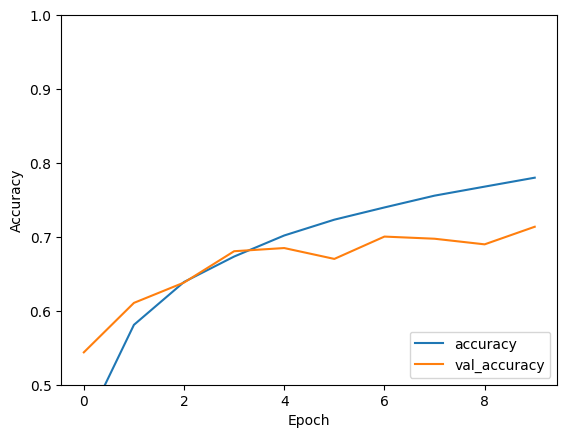

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [11]:
print(test_acc)

0.713699996471405


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.